### Notebook to analyze IFWASTE-Simulation results

In [1]:
import os 
import pandas as pd 
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd


In [2]:
PATH = "/blue/carpena/haasehelen/ifwaste/data/"
CONFIG_PATH = "/blue/carpena/haasehelen/ifwaste/model/config.json"

In [3]:
#PATH = "E:/UF/ifwaste/data/"
#CONFIG_PATH = "E:/UF/ifwaste/model/config.json"

### Loading necessary parameters from config file
- weights per serving of each food category

In [4]:
FGMEAT_KG = FGDAIRY_KG = FGBAKED_KG = FGVEGETABLE_KG = FGDRYFOOD_KG = FGSNACKS_KG = FGSTOREPREPARED_KG = None
with open(CONFIG_PATH) as f:
    config = json.load(f)
    FGMEAT_KG = config["Food"]["FGMeat"]["kg_per_serving"]
    FGDAIRY_KG = config["Food"]["FGDairy"]["kg_per_serving"]
    FGBAKED_KG = config["Food"]["FGBaked"]["kg_per_serving"]
    FGVEGETABLE_KG = config["Food"]["FGVegetable"]["kg_per_serving"]
    FGDRYFOOD_KG = config["Food"]["FGDryFood"]["kg_per_serving"]
    FGSNACKS_KG = config["Food"]["FGSnacks"]["kg_per_serving"]
    FGSTOREPREPARED_KG = config["Food"]["FGStorePrepared"]["kg_per_serving"]
    


In [5]:
lookup_df = pd.DataFrame({
    'Type': ['Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods', 'Baked Goods' ,
    'Snacks, Condiments, Oils & Other', 'Store-Prepared Items'],
    'Servings_to_Kg': [FGMEAT_KG, FGDAIRY_KG, FGVEGETABLE_KG, FGDRYFOOD_KG, FGBAKED_KG, FGSNACKS_KG, FGSTOREPREPARED_KG],
    "Color": ["#116A65", "#00a0e1", "#466eb4", "#e6a532", "#d7642c","#73B55B", "#D82E5E"]
    
})

food_categories = [
    'Meat & Fish', 'Dairy & Eggs', 'Fruits & Vegetables', 'Dry Foods & Baked Goods',
    'Snacks, Condiments, Liquids, Oils, Grease, & Other', 'Store-Prepared Items'
]
reason_colors = {
            "Inedible Parts": "#26547C",
            "Plate Waste": "#FFD166",
            "Spoiled Food": "#EF476F"
        }
status_colors = {
            "Unprepared": "#404E7C",
            "Prepared": "#FF8E72",
            "Preprepared": "#519872"
        }

conversion_factors = {
    "FGMEAT": 0.09,
    "FGDAIRY": 0.109,
    "FGVEGETABLE": 0.116,
    "FGDRYFOOD": 0.065,
    "FGSNACKS": 0.095,
    "FGBAKED": 0.085,
    "FGSTOREPREPARED": 0.095
}
    
colors = ["#116A65", "#00a0e1", "#466eb4", "#e6a532", "#d7642c","#73B55B", "#D82E5E"]

#color_mapping = dict(zip(lookup_df['Type'], lookup_df['Color']))

In [6]:
def load_data() -> dict[str, dict[str, dd.DataFrame]]:
    # Dictionary to store DataFrames for each run
    runs_data = {}

    # List of the main folders to process
    main_folders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]
    # Iterate over each main folder
    for main_folder in main_folders:
        folder_path = os.path.join(PATH, main_folder)  # type: ignore
        
        # Iterate over each run folder inside the main folder
        for run_folder in os.listdir(folder_path):
            run_path = os.path.join(folder_path, run_folder)
            if os.path.isdir(run_path):
                run_id = run_folder  # Use the folder name as the run ID (e.g., 'run_0')
                # Initialize a dictionary to store DataFrames for each log file in this run
                run_logs = {}
                # Get all CSV files in the run folder
                file_names = [
                    f for f in os.listdir(run_path)
                    if os.path.isfile(os.path.join(run_path, f)) and f.endswith('.csv')
                ]
                
                # Read each CSV file into a Dask DataFrame
                for file in file_names:
                    file_path = os.path.normpath(os.path.join(run_path, file))
                    if os.path.exists(file_path):
                        log_name = file[:-4]  # Remove '.csv' to get the log name
                        run_logs[log_name] = dd.read_csv(file_path,assume_missing=True) #assume all values as floats
                
                # Add the logs dictionary to the runs_data under the current run ID
                runs_data[run_id] = run_logs

    return runs_data


In [7]:
import os
import dask.dataframe as dd

def load_merged_data() -> dict[str, dd.DataFrame]:
    file_names = ['log_bought', 'log_eaten', 'log_wasted', 'log_hh_config', "log_still_have",
                "log_hh_daily", "log_sim_config", "log_store_daily", "log_wasted"]
    
    # Dictionary to store merged DataFrames for each CSV type across all runs
    data_dict = {}

    # List of the main folders to process
    main_folders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]
    
    # Iterate over each main folder
    for main_folder in main_folders:
        folder_path = os.path.join(PATH, main_folder)
        
        # Iterate over each run folder inside the main folder
        for run_folder in os.listdir(folder_path):
            run_path = os.path.join(folder_path, run_folder)
            if os.path.isdir(run_path):
                run_id = run_folder.split('_')[-1]  # Extract the run ID from the folder name

                # Iterate over each CSV type
                for csv_type in file_names:
                    file_path = os.path.join(run_path, f'{csv_type}.csv')
                    if os.path.exists(file_path):
                        # Read the CSV file into a Dask DataFrame
                        df = dd.read_csv(file_path, assume_missing=True)
                        
                        # Modify the 'household' column if it exists
                        if 'household' in df.columns:
                            df['household'] = run_id + "_" + df['household'].astype(int).astype(str)
                        if "Unnamed: 0" in df.columns: 
                            df = df.drop(columns=["Unnamed: 0"])
                        
                        # Rename columns that have "Day" in their name to just "Day"
                        for item in df.columns: 
                            if "Day" in item: 
                                df = df.rename(columns={item: "Day"})
                        
                        # Append the DataFrame to the corresponding entry in data_dict
                        if csv_type not in data_dict:
                            data_dict[csv_type] = df
                        else:
                            # Concatenate with the existing DataFrame
                            data_dict[csv_type] = dd.concat([data_dict[csv_type], df], axis=0)

    return data_dict


In [8]:
merged_data = load_merged_data()
data = load_data()

In [9]:
d = merged_data["log_bought"].compute()
d

,household,day,type,servings,days_till_expiry,price_per_serving,sale_type,discount_effect,amount,sale_timer,store,product_ID
0,2024-12-13at14-10_41,0.0,FGDRYFOOD,6.0,39.0,0.5,EnumSales.NONE,EnumDiscountEffect.NONE,2.0,1000.0,"Convenience_store at (1, 4)",FGDRYFOOD60.5
1,2024-12-13at14-10_41,0.0,FGDRYFOOD,20.0,35.0,0.5,EnumSales.NONE,EnumDiscountEffect.NONE,1.0,1000.0,"Convenience_store at (1, 4)",FGDRYFOOD200.5
2,2024-12-13at14-10_41,0.0,FGSTOREPREPARED,12.0,7.0,1.0,EnumSales.NONE,EnumDiscountEffect.NONE,2.0,1000.0,"Convenience_store at (1, 4)",FGSTOREPREPARED121.0
3,2024-12-13at14-10_41,0.0,FGDRYFOOD,10.0,43.0,1.0,EnumSales.NONE,EnumDiscountEffect.NONE,1.0,1000.0,"Discount_retailer at (4, 1)",FGDRYFOOD101.0
4,2024-12-13at14-10_41,0.0,FGSTOREPREPARED,10.0,4.0,1.0,EnumSales.NONE,EnumDiscountEffect.NONE,2.0,1000.0,"Discount_retailer at (4, 1)",FGSTOREPREPARED101.0
...,...,...,...,...,...,...,...,...,...,...,...,...
358,2_0,19.0,FGDAIRY,12.0,3.0,0.6,EnumSales.EXPIRING,EnumDiscountEffect.DISCOUNT40,2.0,1000.0,"Discount_retailer at (1, 0)",FGDAIRY121.0
359,2_0,19.0,FGDRYFOOD,10.0,15.0,1.0,EnumSales.NONE,EnumDiscountEffect.NONE,1.0,1000.0,"Discount_retailer at (1, 0)",FGDRYFOOD101.0
360,2_0,19.0,FGSTOREPREPARED,10.0,5.0,1.0,EnumSales.NONE,EnumDiscountEffect.NONE,1.0,1000.0,"Discount_retailer at (1, 0)",FGSTOREPREPARED101.0
361,2_3,19.0,FGDRYFOOD,10.0,10.0,1.0,EnumSales.NONE,EnumDiscountEffect.NONE,1.0,1000.0,"Discount_retailer at (1, 0)",FGDRYFOOD101.0


In [10]:
# Number of houses
N_HH = data["run_0"]["log_hh_config"]["household"].max().compute() + 1
N_HH

np.float64(5.0)

In [11]:
sim_config = pd.DataFrame(data["run_0"]["log_sim_config"])
DAYS = sim_config[0][0]
DAYS

np.float64(20.0)

In [12]:
EXPERIMENT_KEYS = data.keys()
EXPERIMENT_KEYS

dict_keys(['run_0_2024-12-13at14-10', 'run_0_2024-12-16at10-06', 'run_0_2024-12-13at11-02', 'run_0_2024-12-13at12-58', 'run_0_2024-12-17at09-59', 'run_0_2024-12-17at10-05', 'run_0_2024-12-17at10-09', 'run_0_2024-12-17at09-54', 'run_0_2024-12-16at16-37', 'run_0_2024-12-16at16-52', 'run_0_2024-12-13at11-26', 'run_0_2024-12-13at11-46', 'run_0_2024-12-17at10-08', 'run_0', 'run_0_2024-12-17at09-44', 'run_0_2024-12-13at10-37', 'run_0_2024-12-17at09-50', 'run_0_2024-12-16at16-55', 'run_1', 'run_2'])

## Sanity Checks: 
1. Biomass check


In [13]:
for key in EXPERIMENT_KEYS: 
    bought = data[key]["log_bought"]["servings"] * data[key]["log_bought"]["amount"]
    bought = bought.sum().compute()
    
    eaten = data[key]["log_eaten"]["servings"].sum().compute()
    wasted = data[key]["log_wasted"]["servings"].sum().compute()
    left = data[key]["log_still_have"]["servings"].sum().compute()
    
    print("group: ", key)
    print("bought total servings:\t\t", int(bought))
    print("eaten total servings:\t\t", int(eaten))
    print("wasted total servings:\t\t", int(wasted))    
    print("left last day in servings:\t", int(left))
    
    diff = bought - (eaten + wasted + left)
    print("bought - consumed:\t\t", diff)
    print("------------")

TypeError: 'ArrowStringArray' with dtype string does not support reduction 'sum' with pyarrow version 18.1.0. 'sum' may be supported by upgrading pyarrow.

In [14]:
#what all houes of run 0 should eat in days
should_eat = data["run_0"]["log_hh_config"]["required_servings"].sum().compute() * DAYS
should_eat

np.float64(6851.787779064749)

In [15]:
#how much servings are missing over all hh of run 0 over days
missing_eat = data["run_0"]["log_hh_daily"]["servings"].sum().compute()
missing_eat


np.float64(392.9139395431774)

In [16]:
merged_data.keys()

dict_keys(['log_bought', 'log_eaten', 'log_wasted', 'log_hh_config', 'log_still_have', 'log_hh_daily', 'log_sim_config', 'log_store_daily'])

In [17]:
eaten = should_eat - missing_eat
eaten

np.float64(6458.873839521571)

### Preprocess data for per capita and per household baseline values
have a second datastructure in place that has all the hh merged together for some analysis like average waste per household. 

data <- holds data organized by run

data_merged <- holds data organized as 1 big simulation, hh unique through HH+RUN 



In [18]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

def preprocess_data(dask_df, per_capita):
    config_df = dask_df["log_hh_config"].compute()
    wasted = dask_df["log_wasted"]

    # Merge data with configuration to get household information
    merged_df = dd.merge(wasted, config_df[['household', 'adults', 'children']], on='household', how='inner')

    # Calculate the total number of people
    total_people = 1
    if per_capita:
        total_people = config_df['adults'][0].sum() + config_df['children'][0].sum()
    # Group by day and household, then sum waste and normalize if per capita
    df_grouped = merged_df.groupby(by=['day', 'household'])['servings'].sum().compute()
    df_grouped = df_grouped / total_people

    # Convert to a DataFrame and reset index
    df_grouped = df_grouped.reset_index()

    # Create a DataFrame with all days and houses
    all_houses = list(merged_df['household'].unique().compute())
    all_combinations = pd.MultiIndex.from_product([range(int(DAYS)), all_houses], names=['day', 'household'])

    # Reindex to include all days and houses, filling missing values with 0
    df_complete = df_grouped.set_index(['day', 'household']).reindex(all_combinations, fill_value=0).reset_index()
    print("standard deviation:",df_complete["servings"].std())
    print("mean:", df_complete["servings"].mean())
    # Convert back to a Dask DataFrame
    df_complete = dd.from_pandas(df_complete, npartitions=1)

    

    return df_complete


In [19]:

def plot_waste_as_histogram(data,bins):
    plt.figure(figsize=(10, 6))

    # Histogram with KDE overlay
    sns.histplot(data["servings"], bins=bins, kde=True, color='blue')

    # Add labels and title
    plt.xlabel("Servings", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of wasted servings", fontsize=14)

    # Show the plot
    plt.show()


/blue/carpena/haasehelen/.conda/envs/ifwaste-env/lib/python3.12/site-packages/dask/dataframe/multi.py:521: UserWarning: Merging dataframes with merge column data type mismatches: 
+----------------------------+------------+-------------+
| Merge columns              | left dtype | right dtype |
+----------------------------+------------+-------------+
| ('household', 'household') | object     | string      |
+----------------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


standard deviation: 0.8160868434129293
mean: 0.6191132243072154


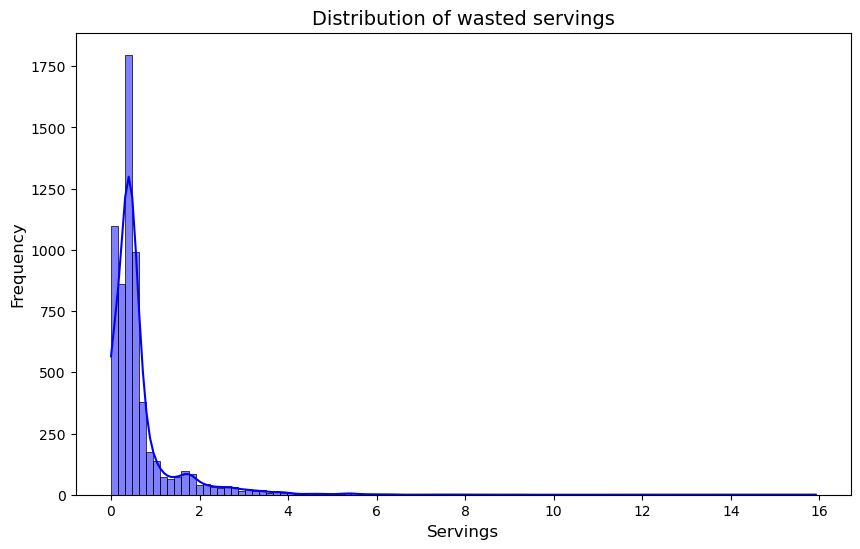

In [20]:
waste_per_capita = preprocess_data(merged_data,True)
plot_waste_as_histogram(waste_per_capita, 100)

/blue/carpena/haasehelen/.conda/envs/ifwaste-env/lib/python3.12/site-packages/dask/dataframe/multi.py:521: UserWarning: Merging dataframes with merge column data type mismatches: 
+----------------------------+------------+-------------+
| Merge columns              | left dtype | right dtype |
+----------------------------+------------+-------------+
| ('household', 'household') | object     | string      |
+----------------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


standard deviation: 29.379126362865453
mean: 22.288076075059756


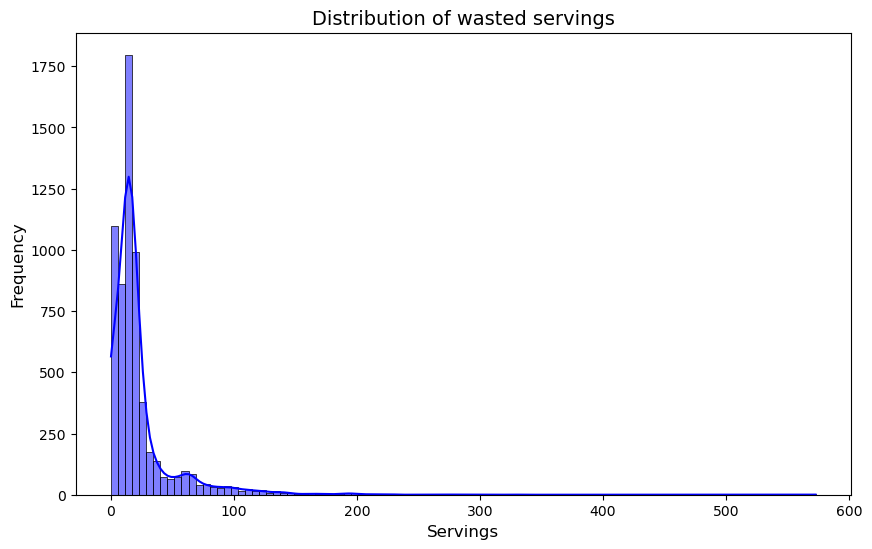

In [21]:
waste_per_hh = preprocess_data(merged_data,False)
plot_waste_as_histogram(waste_per_hh, 100)

In [22]:
def calculate_daily_stats(df_complete):
    daily_stats = df_complete.groupby('day')['servings'].agg(['mean', 'std']).reset_index()
    return daily_stats

stats_0k  = calculate_daily_stats(waste_per_hh)

In [23]:
import numpy as np
import scipy.stats as stats

def calculate_ci(data, n, confidence=0.95):
    
    # Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    # Standard Error of the Mean (SEM)
    sem = data["std"] / np.sqrt(n)
    
    # Confidence interval range
    data["ci_lower"] = data["mean"] - z_score * sem
    data["ci_upper"] = data["mean"] + z_score * sem
    
    return data
n = 5000

# Calculate confidence intervals

ci_df = calculate_ci(stats_0k,  n)


In [24]:
ci_df.head()

,day,mean,std,ci_lower,ci_upper
0,0,16.048134,12.032643,15.714613,16.381656
1,1,17.389635,13.972961,17.002331,17.776938
2,2,15.409961,12.584727,15.061136,15.758785
3,3,17.769659,22.964392,17.133130,18.406188
4,4,32.544441,38.750414,31.470354,33.618528


In [25]:
def calculate_average_by_day(data, category: str, per_capita: bool):
    eaten_statistics = {folder: {'mean': [0] * int(DAYS),
                                'ci_lower': [0] * int(DAYS),
                                'ci_upper': [0] * int(DAYS),
                                "std": 0} for folder in EXPERIMENT_KEYS}  # std is overall, not per day
    for main_folder, dfs in data.items():
        config_df = dfs['log_hh_config'].compute()
        df = dfs[category].compute()

        # Ensure that all houses and all days are present, even if no waste was recorded
        all_days = pd.DataFrame({'day': range(int(DAYS))})
        all_houses = config_df['household'].unique()
        
        # Create a DataFrame with all combinations of houses and days
        house_day_combinations = pd.MultiIndex.from_product([all_days['day'], all_houses], names=['day', 'household'])
        full_df = pd.DataFrame(index=house_day_combinations).reset_index()

        # Merge the full day/house combinations with the actual data, filling missing Kg values with 0
        merged_df = pd.merge(full_df, df, on=['day', 'household'], how='left').fillna(0)

        # Merge with the configuration DataFrame to get the number of people per house
        merged_df = pd.merge(merged_df, config_df[['household', 'adults', 'children']], on='household', how='inner')
        num_houses = len(merged_df['household'].unique())

        daily_totals = merged_df.groupby('day')['servings'].sum()  # Total 'Kg' per day

        total_people = 0
        if per_capita:
            total_people = config_df['adults'].sum() + config_df['children'].sum()
        else:
            total_people = num_houses

        # Loop to calculate per-day averages and confidence intervals
        for day in range(int(DAYS)):
            # Calculate average per day
            avg = daily_totals[day] / total_people 
            eaten_statistics[main_folder]['mean'][day] = avg

            # Sum values for today per "household"
            daily_values = merged_df[merged_df['day'] == day].groupby('household')['servings'].sum()
            # Calculate standard deviation (std)
            std = np.std(daily_values)
            eaten_statistics[main_folder]['std'] = std
            n = len(daily_values)  # Number of houses that reported 'Kg' for the day
            if n > 1 and avg is not None:
                # Calculate SEM for the day
                sem = stats.sem(daily_values)  # Standard error of the mean
                ci = sem * stats.t.ppf(0.975, n - 1)  # 95% CI
                eaten_statistics[main_folder]['ci_lower'][day] = avg - ci
                eaten_statistics[main_folder]['ci_upper'][day] = avg + ci
            else:
                print(f"N is too small for calculating CI on day {day}")
    return eaten_statistics


In [26]:
waste_per_day_capita = calculate_average_by_day(data=data, category="log_wasted", per_capita=True)
waste_per_day = calculate_average_by_day(data, "log_wasted", False)

In [27]:
def plot_average_with_ci(eaten_statistics):
    # Set the figure size and DPI for higher resolution (300 DPI is standard for papers)
    plt.figure(figsize=(10, 6), dpi=300)
    
    for i, (main_folder, stats) in enumerate(eaten_statistics.items()):
        #label = legend_labels.get(main_folder, main_folder)
    
        days = range(len(stats['mean']))  # X-axis is the number of days
        mean_values = np.array(stats['mean'])
        ci_lower = np.array(stats['ci_lower'])
        ci_lower[ci_lower < 0] = 0 
        ci_upper = np.array(stats['ci_upper'])

        # Only plot if there is valid data
        if mean_values[0] is not None:
            plt.plot(days, mean_values, '-o', color=colors[i % len(colors)])

            # Fill between the confidence intervals
            plt.fill_between(days, ci_lower, ci_upper, alpha=0.3, color=colors[i % len(colors)])

    # Set axis labels
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Daily food waste per Person (in kg)', fontsize=12)
    
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2137736/1326328169.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


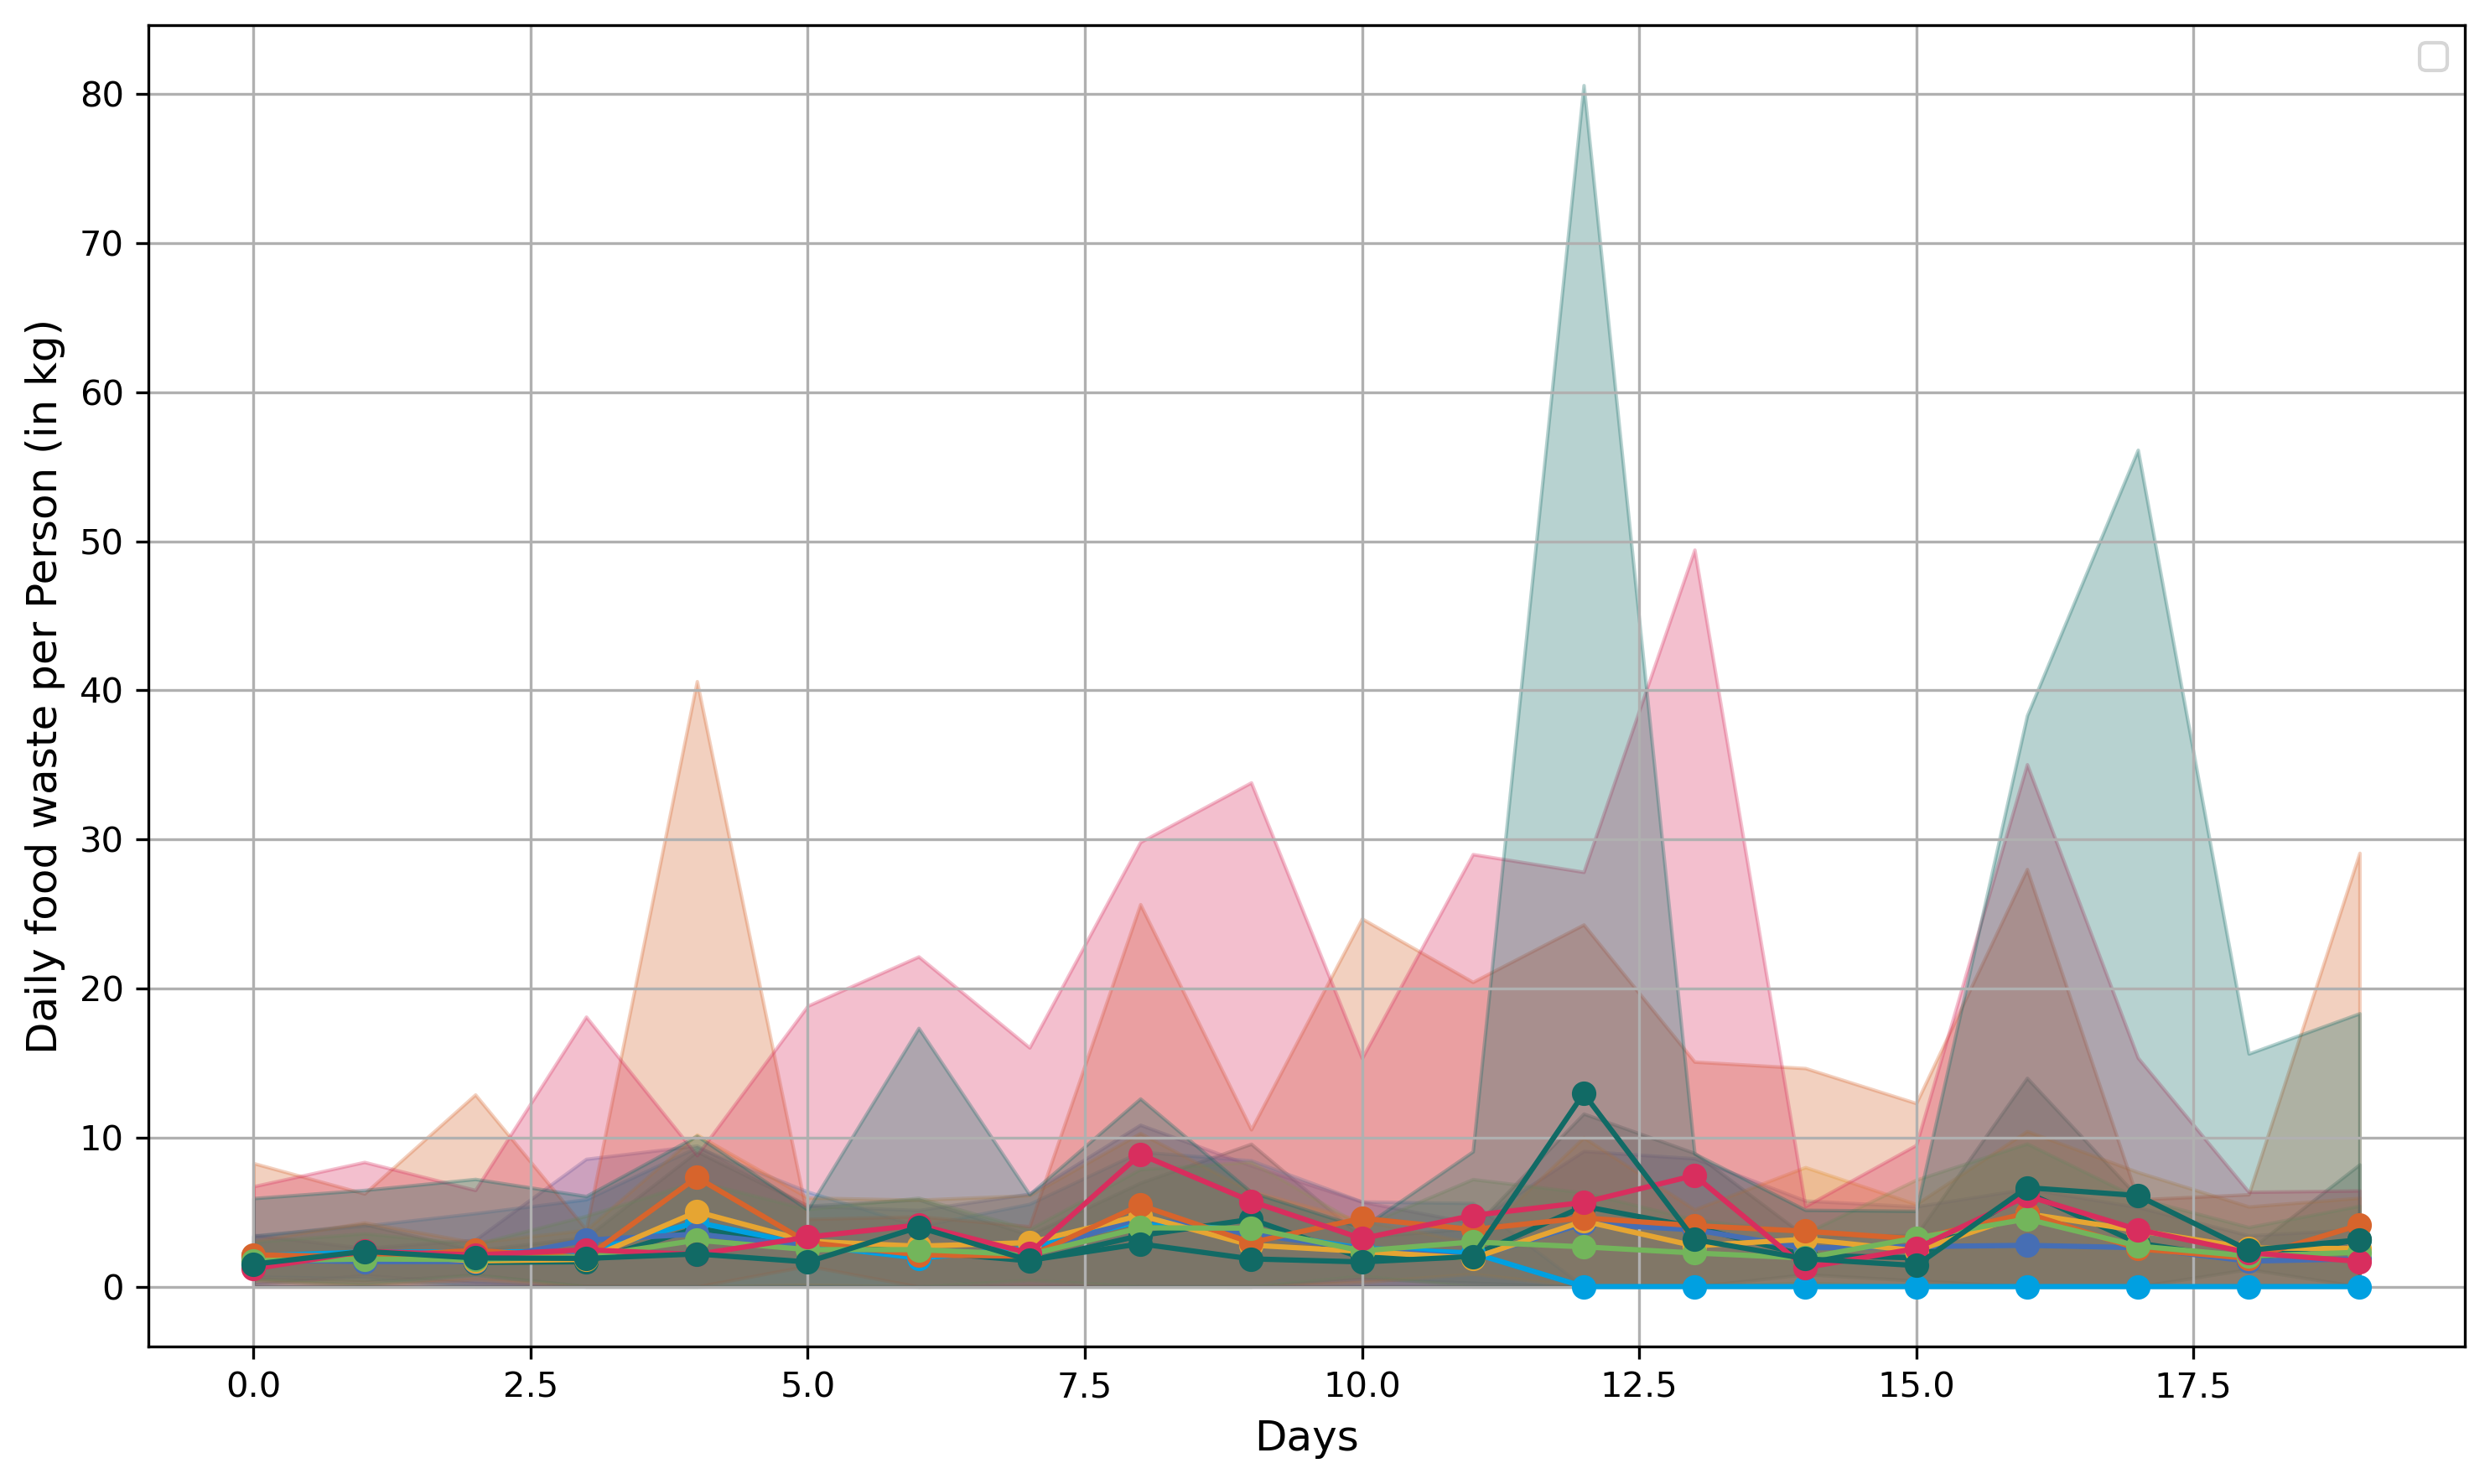

In [28]:
plot_average_with_ci(waste_per_day_capita)

/tmp/ipykernel_2137736/1326328169.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


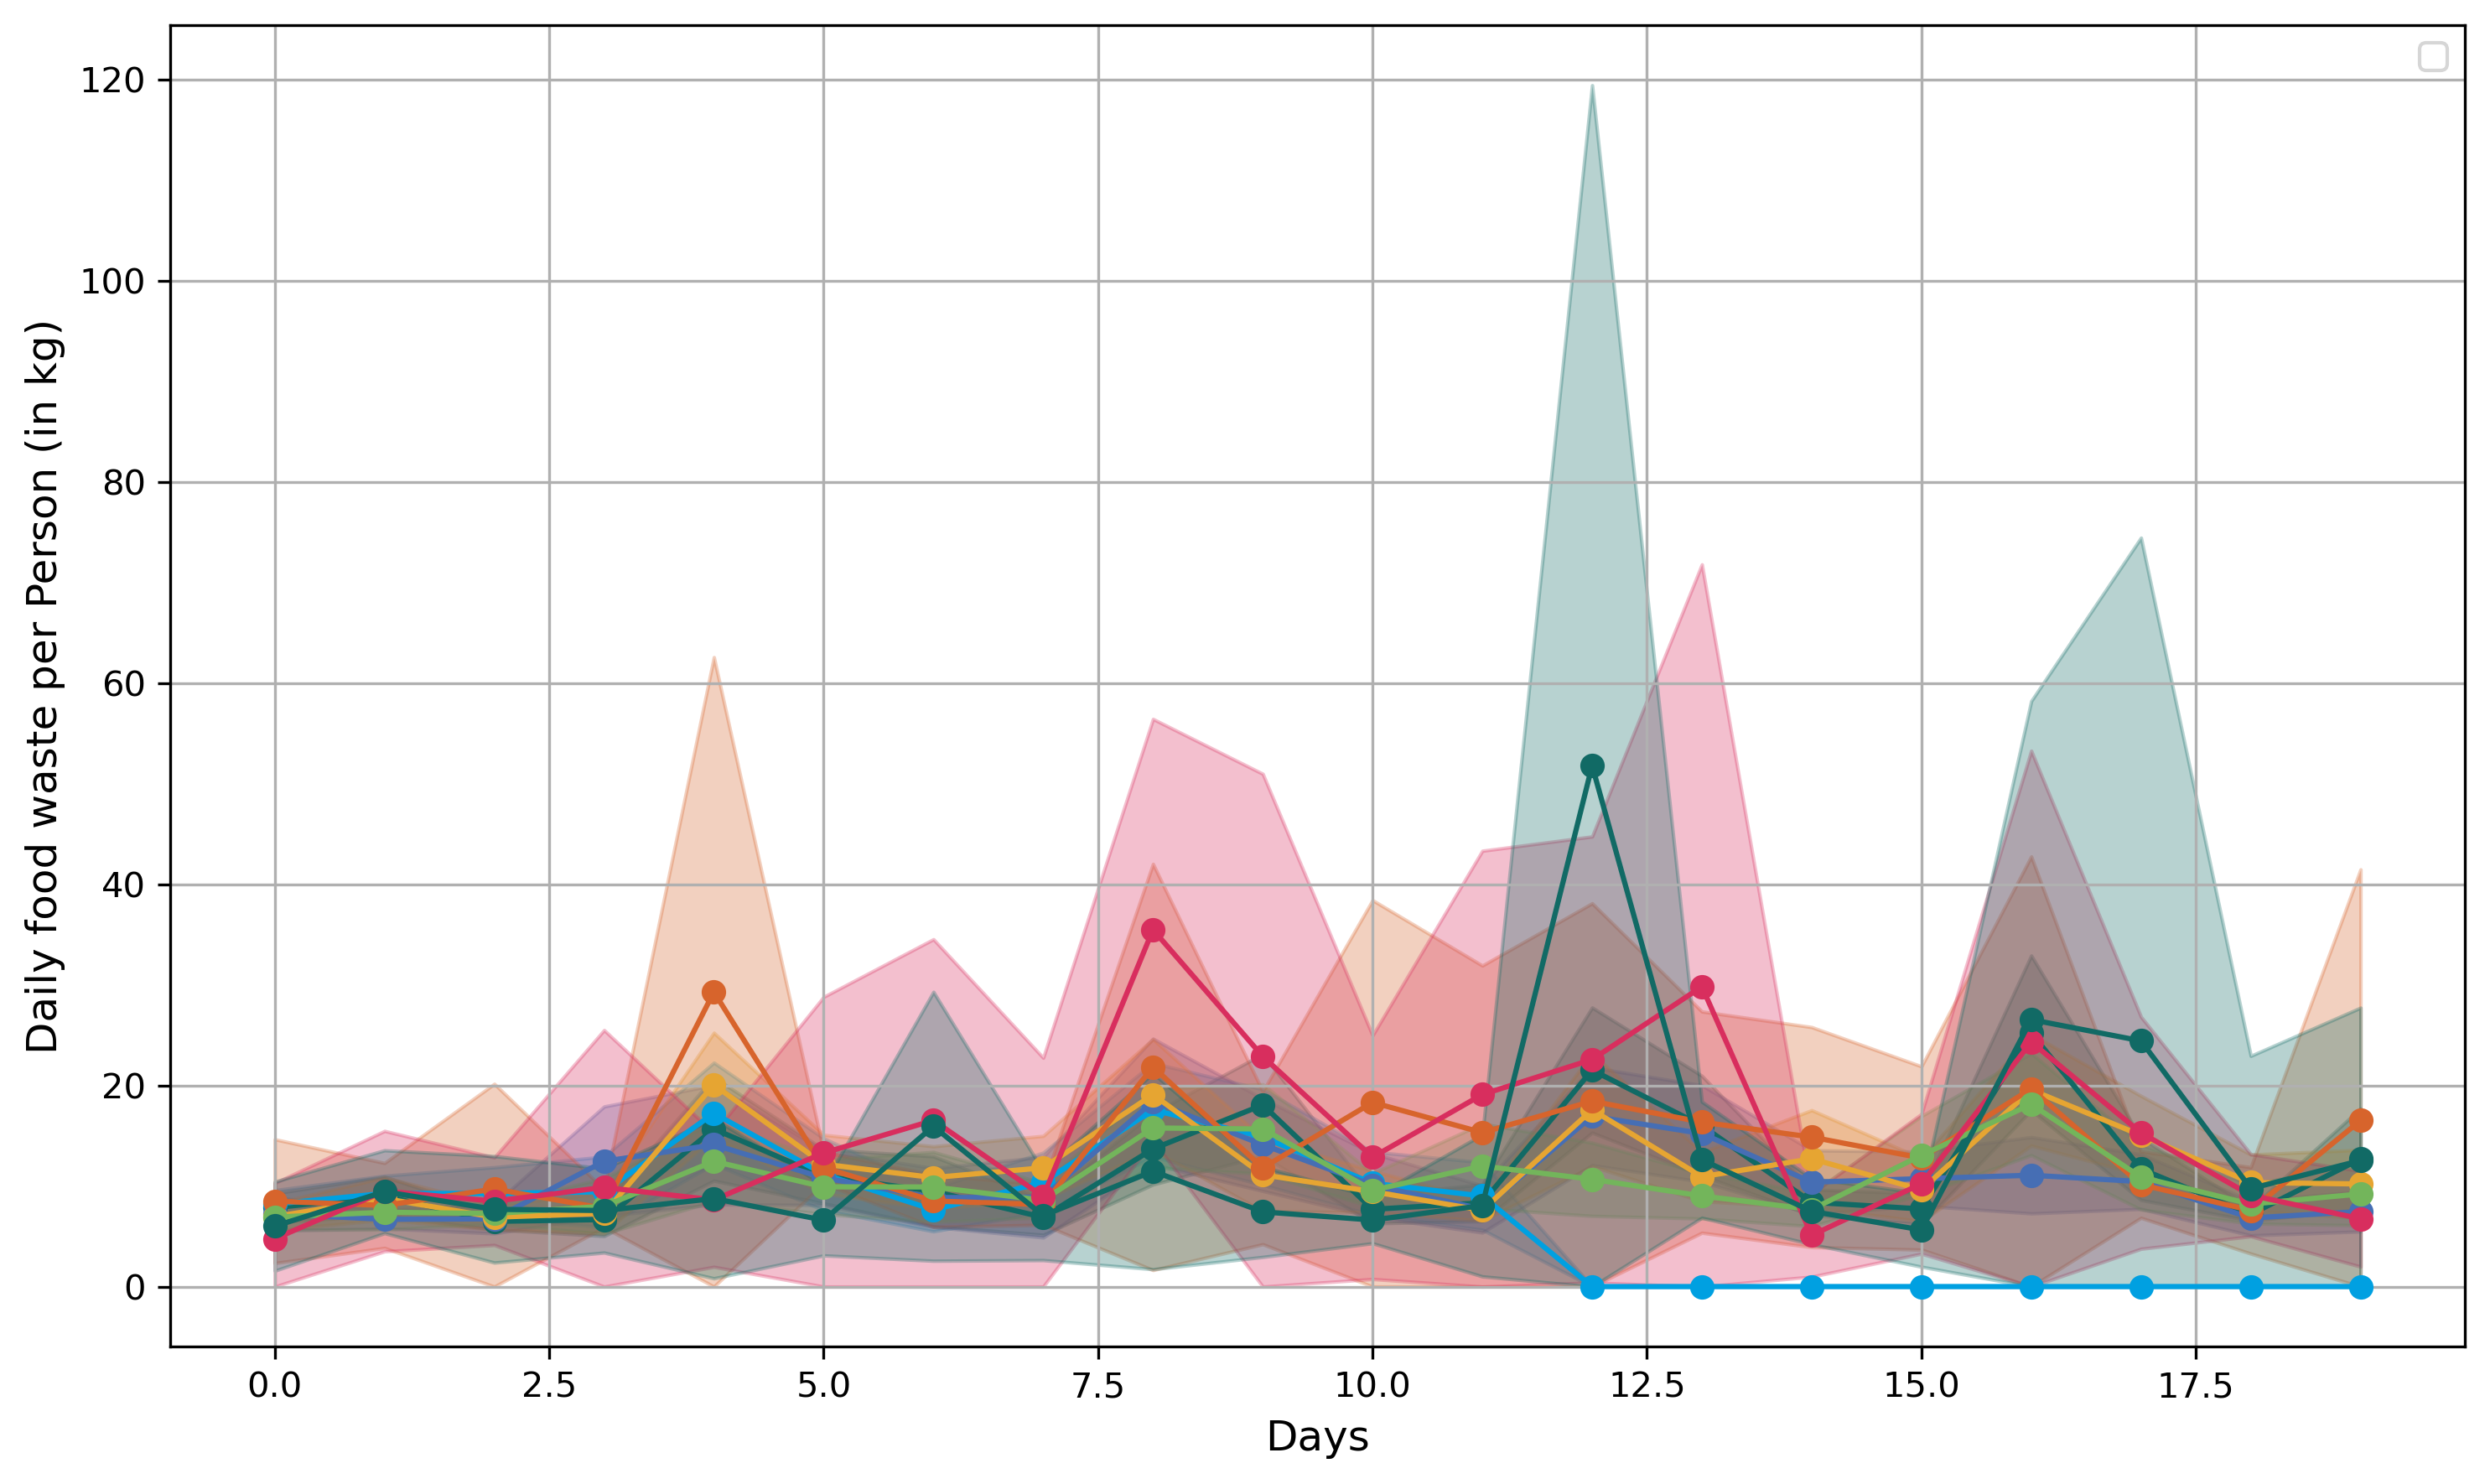

In [29]:
plot_average_with_ci(waste_per_day)

In [30]:
FOLDER = "debug"

In [31]:
def generate_avg_std_table(dataset,per_capita: bool):
    for folder in EXPERIMENT_KEYS:
        config_df = data[folder]['log_hh_config'].compute()
        total_people = 1
        #if per_capita:
        #    total_people = config_df['adults'][0].values[0] + config_df['children'][0].values[0]
            
        if per_capita:
            total_people = config_df['adults'].sum() + config_df['children'].sum()
        else:
            total_people = N_HH #TODO check, in old code was just 1
        
        avg = sum(dataset[folder]["mean"]) / (len(dataset[folder]["mean"]))
        
        df = data[folder]["log_wasted"].compute()
        df = pd.merge(df, config_df[['household', 'adults', 'children']], on='household', how='inner')

        # Group by Day and household, then calculate daily total per house
        df_grouped = df.groupby(by=['day', 'household'])['servings'].sum()  
        df_grouped = df_grouped / total_people
        # Calculate the standard deviation across the entire dataset
        std = df_grouped.std()

        # Print results
        print(f"Group: {folder}: {avg:.2f} avg, {std:.5f} std")


In [32]:
generate_avg_std_table(waste_per_day_capita,True)

Group: run_0_2024-12-13at11-02: 2.89 avg, 0.06078 std
Group: run_0_2024-12-13at12-58: 1.68 avg, 0.06212 std
Group: run_0_2024-12-13at11-26: 2.69 avg, 0.06053 std
Group: run_0_2024-12-13at11-46: 2.97 avg, 0.05985 std
Group: run_0: 3.44 avg, 0.60100 std
Group: run_0_2024-12-13at10-37: 2.63 avg, 0.05775 std
Group: run_1: 3.67 avg, 0.77170 std
Group: run_2: 3.17 avg, 0.94367 std


In [33]:
generate_avg_std_table(waste_per_day,False)

Group: run_0_2024-12-13at11-02: 11.56 avg, 2.43117 std
Group: run_0_2024-12-13at12-58: 6.71 avg, 2.48491 std
Group: run_0_2024-12-13at11-26: 10.75 avg, 2.42134 std
Group: run_0_2024-12-13at11-46: 11.90 avg, 2.39412 std
Group: run_0: 13.77 avg, 2.40399 std
Group: run_0_2024-12-13at10-37: 10.51 avg, 2.31008 std
Group: run_1: 14.67 avg, 3.08682 std
Group: run_2: 12.67 avg, 3.77469 std


In [34]:
import numpy as np
import pandas as pd
from scipy import stats

def calculate_average_LOC(data, bins: list[float], category: str, per_capita: bool):

    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    eaten_statistics = {main_folder: {'mean': [None] * len(interval_labels),
                                      'ci_lower': [None] * len(interval_labels),
                                      'ci_upper': [None] * len(interval_labels)}
                        for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        config_df = dfs['config'].compute()
        config_df['concern_interval'] = pd.cut(config_df['lvl_of_concern'], bins=interval_labels)
        df = dfs[category][dfs[category]['day'] >= 14].compute()
        merged_df = pd.merge(df, config_df[['household', 'concern_interval', 'adults', 'children']],
                            on='household', how='inner')

        for idx, interval in enumerate(interval_labels):
            group = config_df[config_df['concern_interval'] == interval]
            household_ids = group['household'].tolist()
            interval_df = merged_df[merged_df['household'].isin(household_ids)]
            
            if not group.empty and not interval_df.empty:
                if per_capita: 
                    total_people = group['adults'].sum() + group['children'].sum()
                else: 
                    total_people = len(group)
                    
                total = interval_df.groupby(['day', 'household'])['servings'].sum()
                n = len(total)
                print(household_ids)
                print(n)
                
                total = total.sum()
                
                avg = total / (total_people * (DAYS - 14))
                eaten_statistics[main_folder]['mean'][idx] = avg
                
                # Calculate confidence interval
                if n > 1:  # To avoid division by zero or invalid CI calculation
                    sem = stats.sem(interval_df['servings'])
                    ci = sem * stats.t.ppf(0.975, n - 1)  # 95% CI
                    eaten_statistics[main_folder]['ci_lower'][idx] = avg - ci
                    eaten_statistics[main_folder]['ci_upper'][idx] = avg + ci
                else:
                    eaten_statistics[main_folder]['ci_lower'][idx] = np.nan
                    eaten_statistics[main_folder]['ci_upper'][idx] = np.nan
    
    return eaten_statistics


In [35]:
import matplotlib.pyplot as plt

def plot_average_LOC_with_ci(eaten_statistics, interval_labels):
    plt.figure(figsize=(10, 6))
    
    for main_folder in EXPERIMENT_KEYS:
        if main_folder in eaten_statistics:
            stats = eaten_statistics[main_folder]
            # Get the legend label based on the mapping
            #label = legend_labels.get(main_folder, main_folder)
            
            # Plot average values with error bars for the confidence interval
            plt.errorbar(interval_labels.mid, stats['mean'], 
                        yerr=[np.array(stats['mean']) - np.array(stats['ci_lower']),
                            np.array(stats['ci_upper']) - np.array(stats['mean'])],
                        fmt='-o', capsize=5)

    plt.xlabel('Level of Concern (in %)')
    plt.ylabel('Daily Food Waste (in Kg)')
    plt.legend()
    plt.xticks(ticks=interval_labels.mid, labels=[f"{int(i.left*100)}-{int(i.right*100)}%" for i in interval_labels])
    plt.grid(True)
    plt.show()


In [36]:
def calculate_average_daily(data, bins: list[float], category: str, per_capita: bool):
    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    eaten_statistics = {main_folder: [0] * len(interval_labels) for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        config_df = dfs['log_hh_config'].compute()
        config_df['concern_interval'] = pd.cut(config_df['lvl_of_concern'], bins=interval_labels)
        df = dfs[category][dfs[category]['day'] >= 14].compute()
        
        # Special handling for "log_bought" category
        if category == "log_bought":
            df['total_kg'] = df["servings"] * conversion_factors[df["type"].values[0]]
        else:
            # Calculate total kg for categories like "log_eaten", "log_wasted"
            df = pd.merge(df, config_df[['household', 'concern_interval', 'adults', 'children']],
                        on='household', how='inner')
            if not df.empty and all(col in df.columns for col in conversion_factors):
                df['total_kg'] = sum(df[col] * conversion_factors[col] for col in conversion_factors)
            else:
                df['total_kg'] = 0

        for idx, interval in enumerate(interval_labels):
            group = config_df[config_df['concern_interval'] == interval]
            household_ids = group['household'].tolist()
            interval_df = df[df['household'].isin(household_ids)]

            if not group.empty and not interval_df.empty:
                total_people = group['adults'].sum() + group['children'].sum() if per_capita else len(group)
                total = interval_df['total_kg'].sum()
                avg = total / (total_people * (DAYS - 14))
                eaten_statistics[main_folder][idx] = avg

    return eaten_statistics


In [37]:

# Calculate the average daily amount eaten per person grouped by LevelOfConcern intervals
bins = [i / 10 for i in range(11)] #10% increments
# Define intervals for x-axis labels
intervals = ['0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%']

average_eaten_by_concern = calculate_average_daily(data,bins=bins,category="log_eaten", per_capita=True)
average_wasted_by_concern = calculate_average_daily(data,bins=bins,category="log_wasted", per_capita=True)
average_bought_by_concern = calculate_average_daily(data,bins=bins,category="log_bought", per_capita=True)

average_eaten_by_concern_hh = calculate_average_daily(data,bins=bins,category="log_eaten", per_capita=False)
average_wasted_by_concern_hh = calculate_average_daily(data,bins=bins,category="log_wasted", per_capita=False)
average_bought_by_concern_hh = calculate_average_daily(data,bins=bins,category="log_bought", per_capita=False)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [38]:
# Calculate percentage difference
percentage_difference = {}
for key in average_wasted_by_concern_hh:
    # Calculate percentage for each value
    percentage_difference[key] = [
        (v1 / v2)*100 if v2 != 0 else None
        for v1, v2 in zip(average_wasted_by_concern_hh[key], average_bought_by_concern_hh[key])
    ]
percentage_difference

NameError: name 'average_wasted_by_concern_hh' is not defined

/tmp/ipykernel_2137736/3758654698.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Categories')


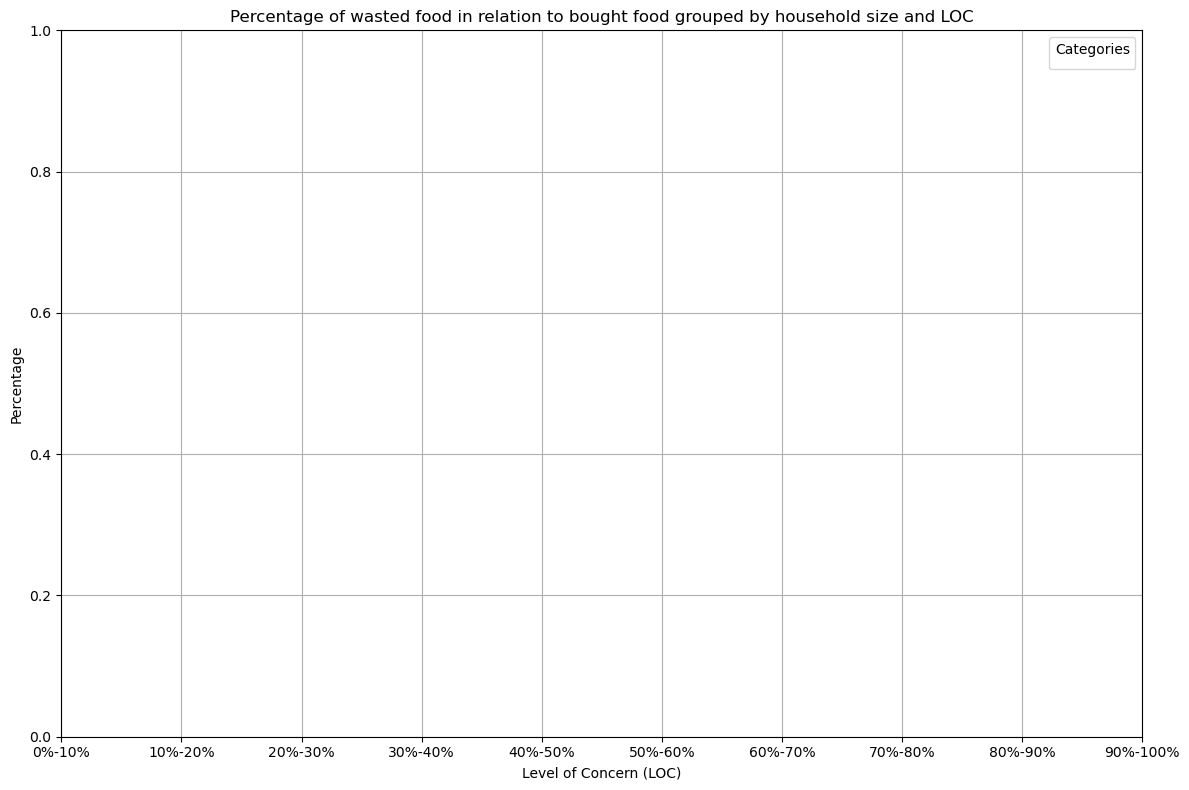

In [39]:

# Create a figure and axis
plt.figure(figsize=(12, 8))

# Plot each category
for key, values in percentage_difference.items():
    plt.plot(values, label=key, marker='o')

# Add titles and labels
plt.title('Percentage of wasted food in relation to bought food grouped by household size and LOC')
plt.xlabel('Level of Concern (LOC)')
plt.xticks(ticks=range(len(intervals)), labels=intervals)
plt.ylabel('Percentage')
plt.legend(title='Categories')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [40]:
import matplotlib.pyplot as plt

def plot_average(average: dict, category_title: str, intervals: list[str], is_household: bool = False):
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot each main_folder data as a separate line
    for main_folder, values in average.items():
        plt.plot(intervals, values, marker='o', label=main_folder)

    # Customize the plot
    group = "Household" if is_household else "Person"
    
    # Set axis labels
    plt.xlabel('Level of Concern Interval (in %)')
    plt.ylabel(f'Average Daily {category_title} Amount (in Kg) per {group}')
    
    # Add grid
    plt.grid(True)
    
    # Rotate the x-axis tick labels
    plt.xticks(rotation=45)
    
    # Add the legend anchored to the top right corner
    plt.legend(title='Run', loc='upper right', bbox_to_anchor=(1.05, 1), fontsize=10)

    # Adjust layout to prevent clipping of elements
    plt.tight_layout()
    
    # Show the plot
    plt.show()


In [41]:
plot_average(average_bought_by_concern, "Bought", intervals)
plot_average(average_wasted_by_concern, "Wasted", intervals)
plot_average(average_eaten_by_concern, "Eaten", intervals)
plot_average(average_bought_by_concern_hh, "Bought", intervals, True)
plot_average(average_eaten_by_concern_hh, "Eaten", intervals, True)
plot_average(average_wasted_by_concern_hh, "Wasted", intervals, True)

NameError: name 'average_bought_by_concern' is not defined

In [42]:
import pandas as pd
import dask.dataframe as dd

def get_average_by_loc(data, bins: list[float], category: str, per_capita: bool):
    # Define intervals
    interval_labels = pd.IntervalIndex.from_breaks(bins, closed='right')
    individual_data = {main_folder: [] for main_folder in data.keys()}

    for main_folder, dfs in data.items():
        result = pd.DataFrame()
        
        config_df = dfs['log_hh_config'].compute()
        config_df['concern_interval'] = pd.cut(config_df['lvl_of_concern'], bins=interval_labels)
        category_df = dfs[category][dfs[category]['day'] >= 14].compute()
        merged_df = pd.merge(category_df, config_df[['household', 'concern_interval', 'adults', 'children']],
                            on='household', how='inner')

        for interval in interval_labels:
            group = config_df[config_df['concern_interval'] == interval]
            
            household_ids = group['household'].tolist()
            interval_data_df = merged_df[merged_df['household'].isin(household_ids)]
            
            for id in household_ids:
                if per_capita:
                    total_people = group[group['household'] == id]['adults'].sum() + group[group['household'] == id]['children'].sum()
                else:
                    total_people = len(group)
                
                # Calculate individual samples
                total_eaten = interval_data_df[interval_data_df['household'] == id]['kg'].sum()
                days = category_df['day'].max() + 1 - 14
                average = total_eaten / (total_people * days) if days > 0 else 0

                new_row = pd.DataFrame({
                    "lvl_of_concern": [interval],
                    "household": [id], 
                    "mean": [average]
                })

                result = pd.concat([result, new_row], ignore_index=True)
                
        result = dd.from_pandas(result, npartitions=1)
        individual_data[main_folder] = result
        
    return individual_data


In [43]:
sorted_wasted = get_average_by_loc(data=data, bins=bins, category="log_wasted", per_capita=True)

KeyError: 'kg'

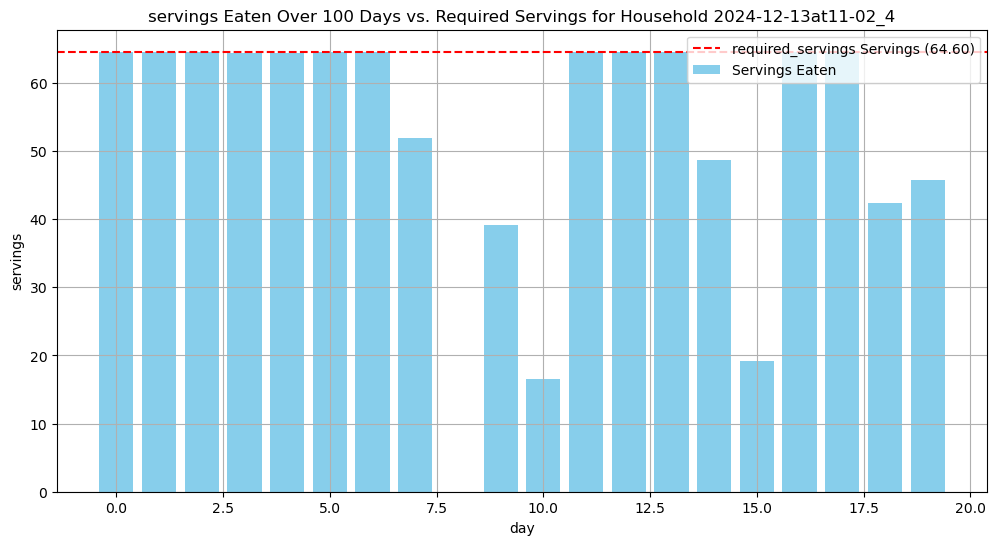

In [44]:
eaten_df = merged_data["log_eaten"]
config_df = merged_data["log_hh_config"]

household_group = eaten_df["household"].unique().compute()[0]
household_group = household_group.sample(1)[0]
hh_servings = eaten_df[eaten_df["household"] == household_group].groupby("day")["servings"].sum().compute()
hh_servings = hh_servings.reindex(range(int(DAYS)), fill_value=0)
required_servings = config_df[config_df["household"] == household_group]["required_servings"].compute().iloc[0]

# Plotting
plt.figure(figsize=(12, 6))
days = range(0,int(DAYS))
plt.bar(days, hh_servings, color='skyblue', label="Servings Eaten")
plt.axhline(y=required_servings, color='r', linestyle='--', linewidth=1.5, label=f"required_servings Servings ({required_servings:.2f})")

plt.title(f"servings Eaten Over 100 Days vs. Required Servings for Household {household_group}")
plt.xlabel("day")
plt.ylabel("servings")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

def plot_behavior(dataset, household): 
    df_daily = dataset["log_hh_daily"]
    print(df_daily.head)
    df_daily = df_daily[df_daily["household"] == household]
    
    # Select only the desired columns
    columns = ["EEF", "cooked", "quick_cook", "ate_leftovers"]
    df_filtered = df_daily[columns]
    df_filtered.index = df_filtered.index.astype(int)
    df_filtered = df_filtered.compute()
    print(len(df_filtered))
    binary_cmap = ListedColormap(["#d1495b", "#7ca982"])

    plt.figure(figsize=(14, 8))  # Increased width to accommodate the new column
    ax = sns.heatmap(
        df_filtered.T,               # Transpose to get activities on y-axis
        cmap=binary_cmap,            # Use the binary colormap
        cbar=True,                   # Enable the color bar (legend)
        linewidths=0.5,
        linecolor='gray',
        vmin=0, vmax=1,              # Set limits to binary values
        cbar_kws={'ticks': [0, 1], 'label': 'Activity Occurrence'}  # Set binary ticks
    )
    
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0 (No)', '1 (Yes)'])
    
    row_sums = df_filtered.sum(axis=0)  # Sum each column
    for i, sum_value in enumerate(row_sums):
        ax.text(df_filtered.shape[0], i + 0.5, f'{sum_value:.0f}', ha='left', va='center', color='black')

    # Set x-axis labels
    ax.set_xticks(range(0, int(DAYS), 10))  # Show every 10th day on the x-axis
    ax.set_xticklabels(range(0, int(DAYS), 10))  # Label the x-axis with corresponding day numbers

    plt.title('Daily Activity Heatmap')
    plt.xlabel('Day')
    plt.ylabel('Activity')

    plt.show()


<bound method FrameBase.head of Dask DataFrame Structure:
              household      day   budget servings      EEF   cooked ate_leftovers quick_cook shopping_time cooking_time
npartitions=1                                                                                                           
                float64  float64  float64  float64  float64  float64       float64    float64       float64      float64
                    ...      ...      ...      ...      ...      ...           ...        ...           ...          ...
Dask Name: read_csv, 1 expression
Expr=ReadCSV(b9525a0)>
20


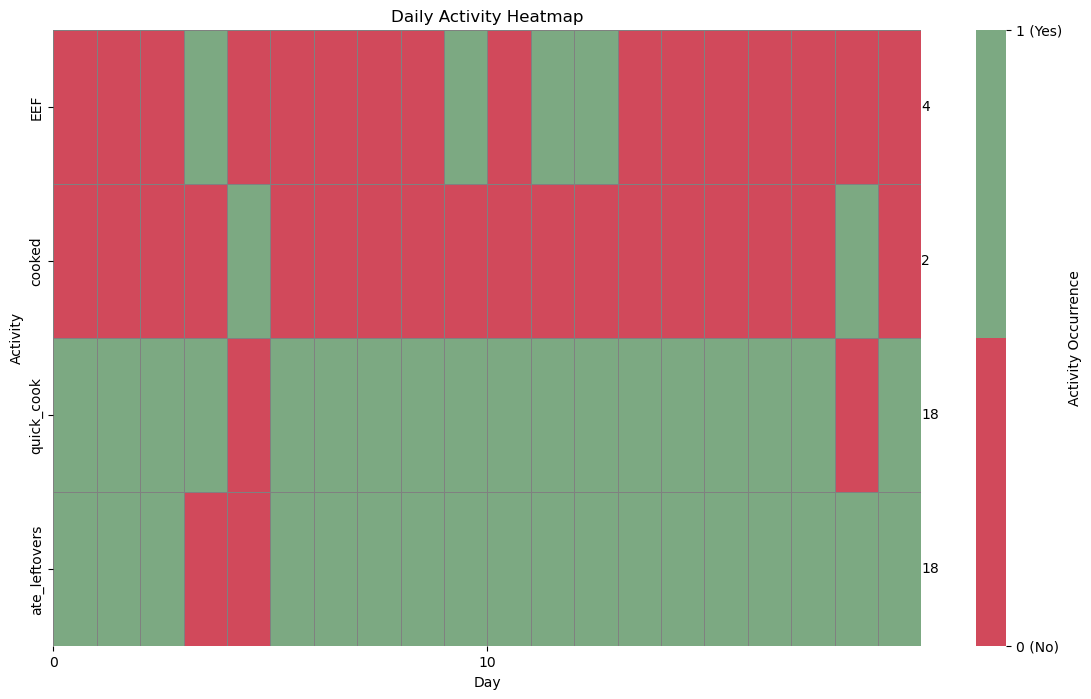

In [46]:
plot_behavior(data["run_0"],0)


In [47]:
def plot_waste_type_hh(dataset, hhID,category):
    df_wasted = dataset["log_wasted"]
    
    if len(df_wasted)>0 and all(col in df_wasted.columns for col in conversion_factors):
        df_wasted['kg'] = sum(df_wasted[col] * conversion_factors[col] for col in conversion_factors)
    plt.figure(figsize=(20, 10), dpi=300)        
            
    hh_wasted = df_wasted[(df_wasted['household'] == hhID) & (df_wasted["kg"] > 0)]
    
    hh_wasted = hh_wasted.groupby(["day", category])["kg"].sum()
    
    color_set = reason_colors
    if category == "status":
        color_set = status_colors 
        
    hh_wasted = hh_wasted.compute().unstack(fill_value=0).reindex(columns=color_set.keys(), fill_value=0)
    hh_wasted.plot(kind='bar', stacked=True, color=[color_set.get(r, 'gray') for r in hh_wasted.columns], ax=plt.gca())
    
    plt.xlabel("day", fontsize=18)
    plt.xlim(0,int(DAYS))
    plt.xticks(range(0, int(DAYS) + 1, 1)) 
    plt.ylabel("kg", fontsize=18)
    plt.legend(title=category, fontsize=18, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



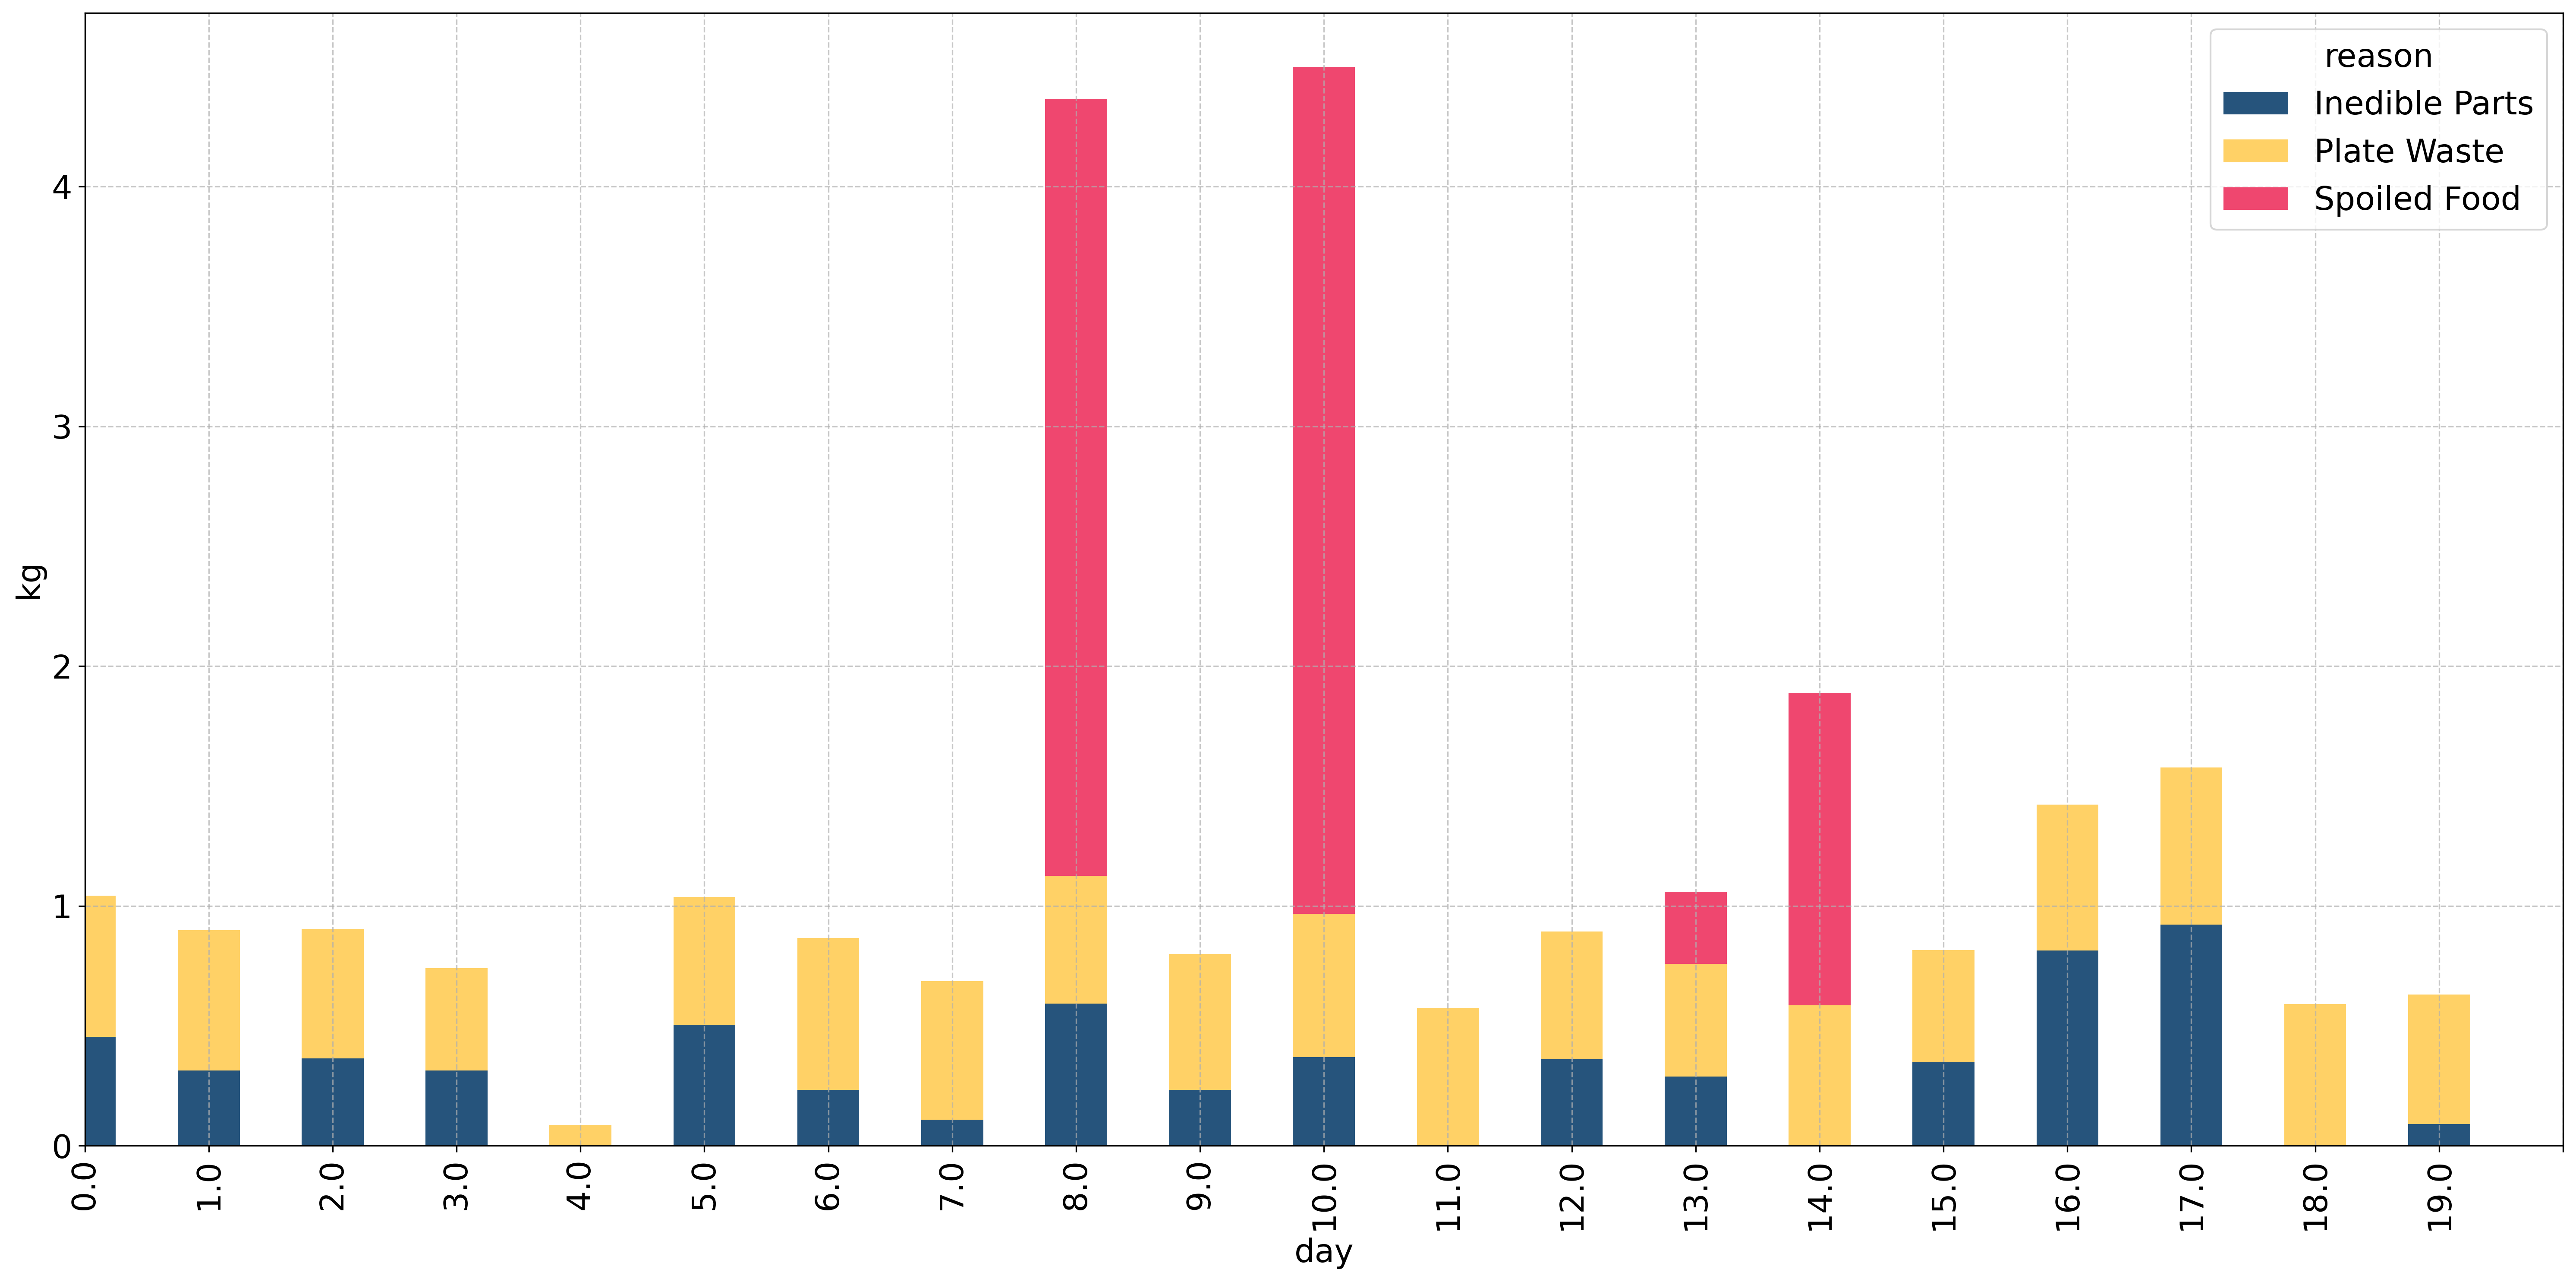

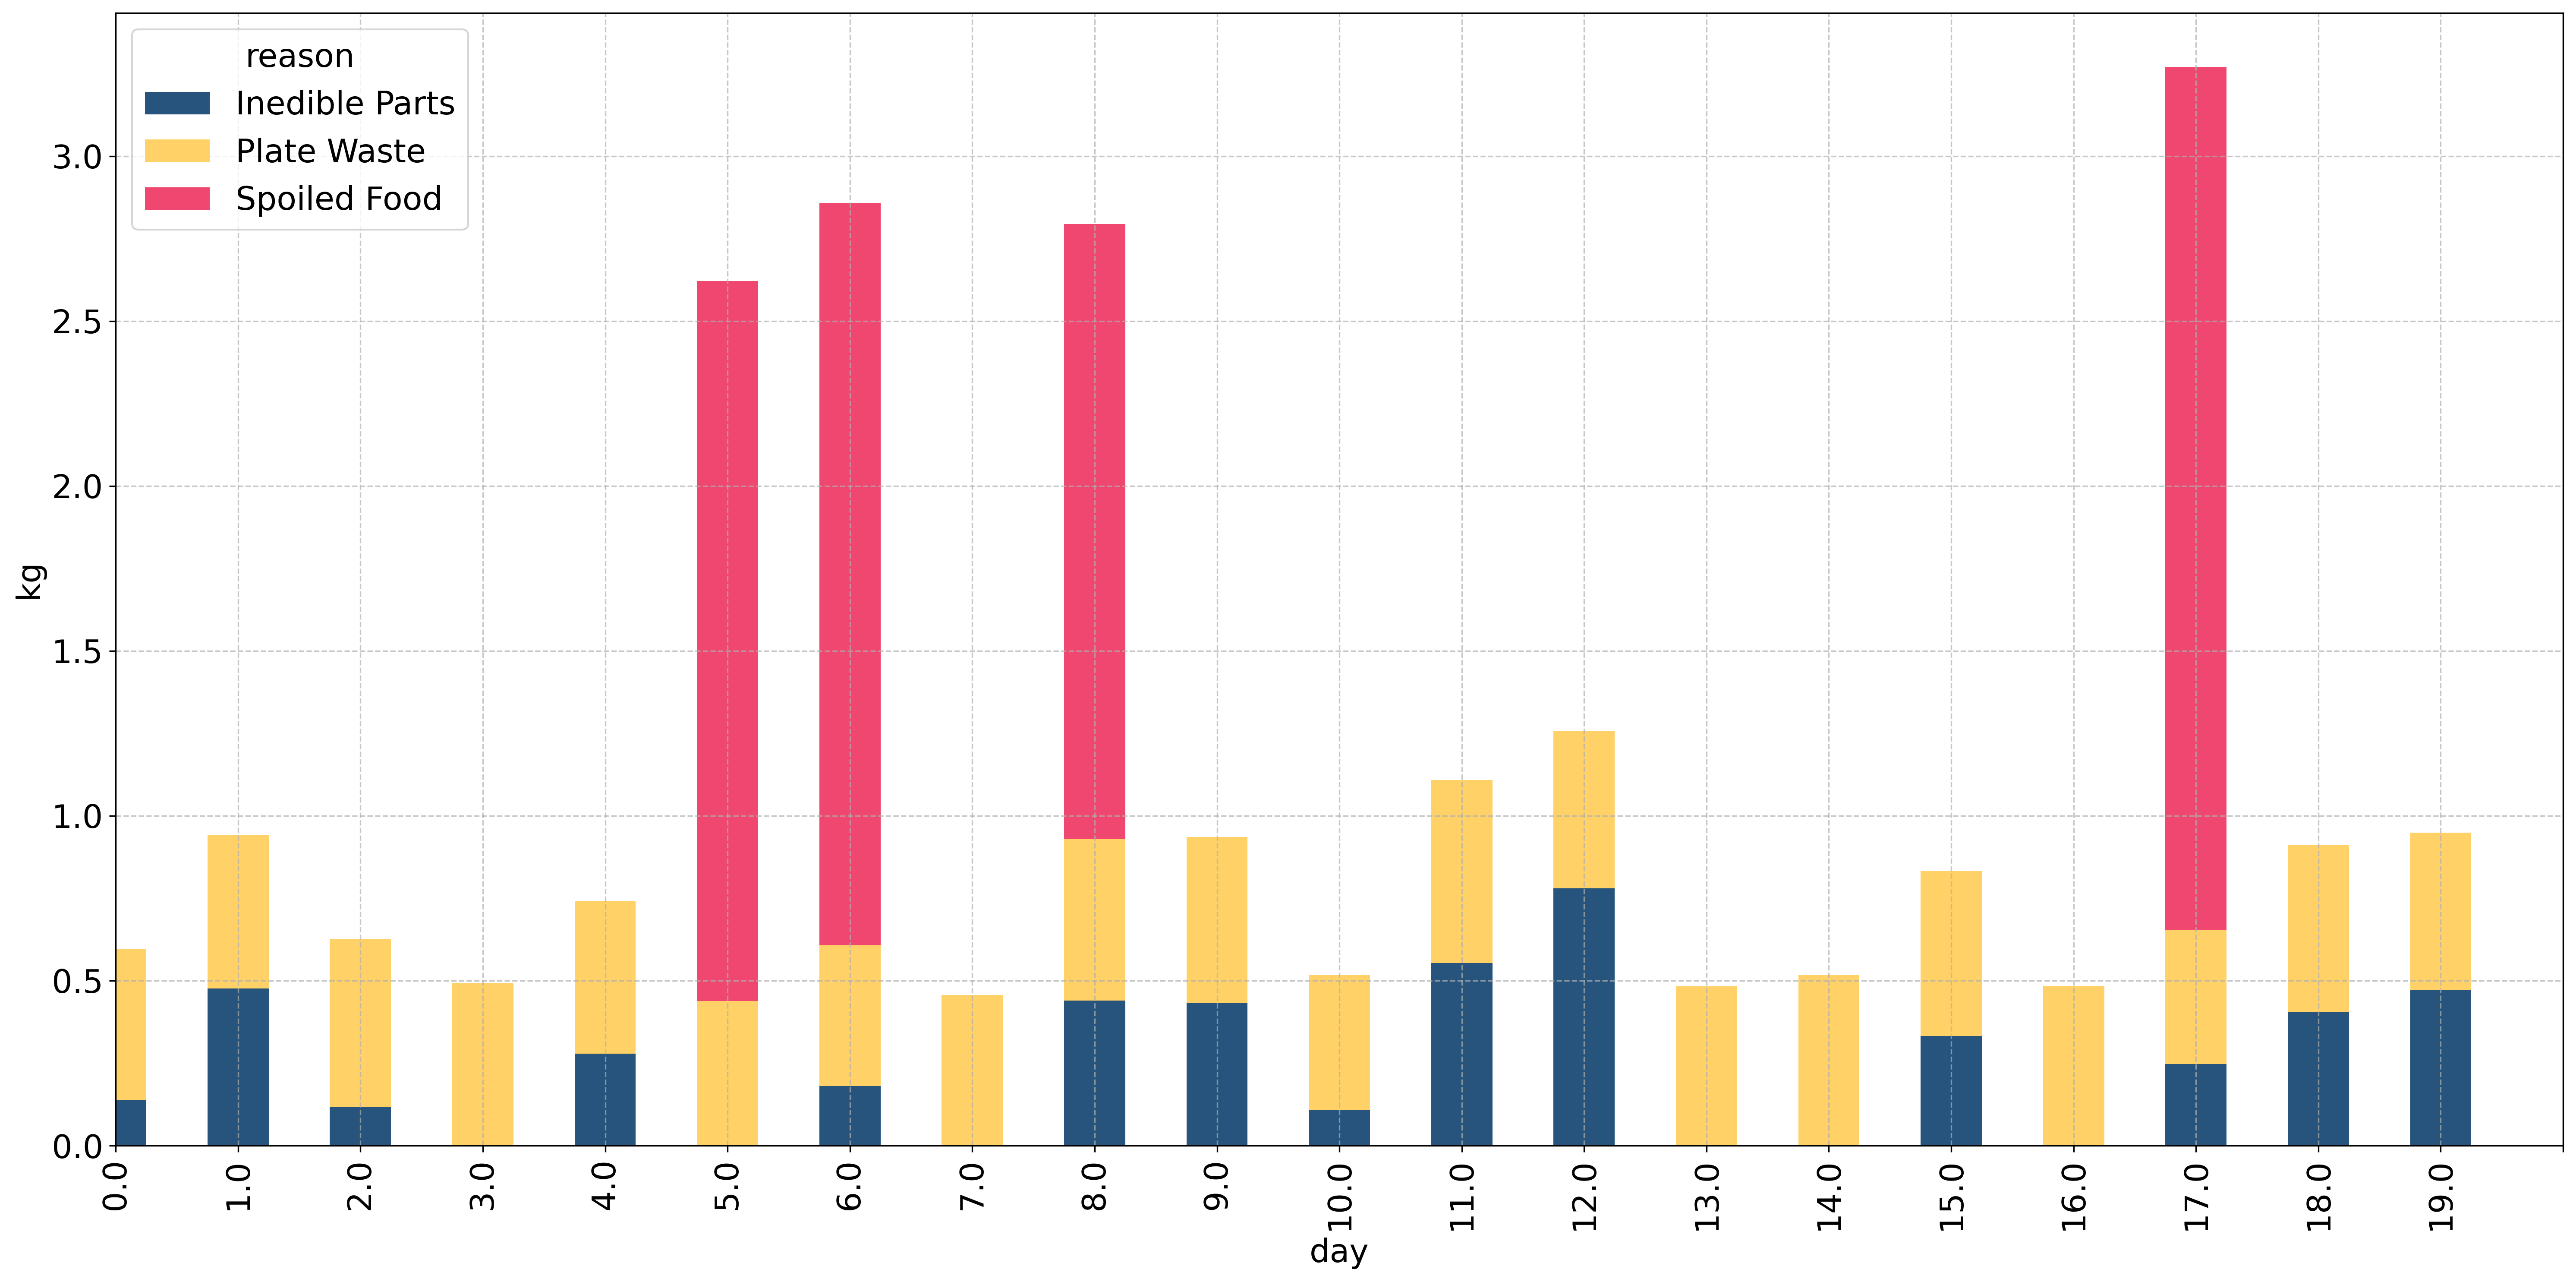

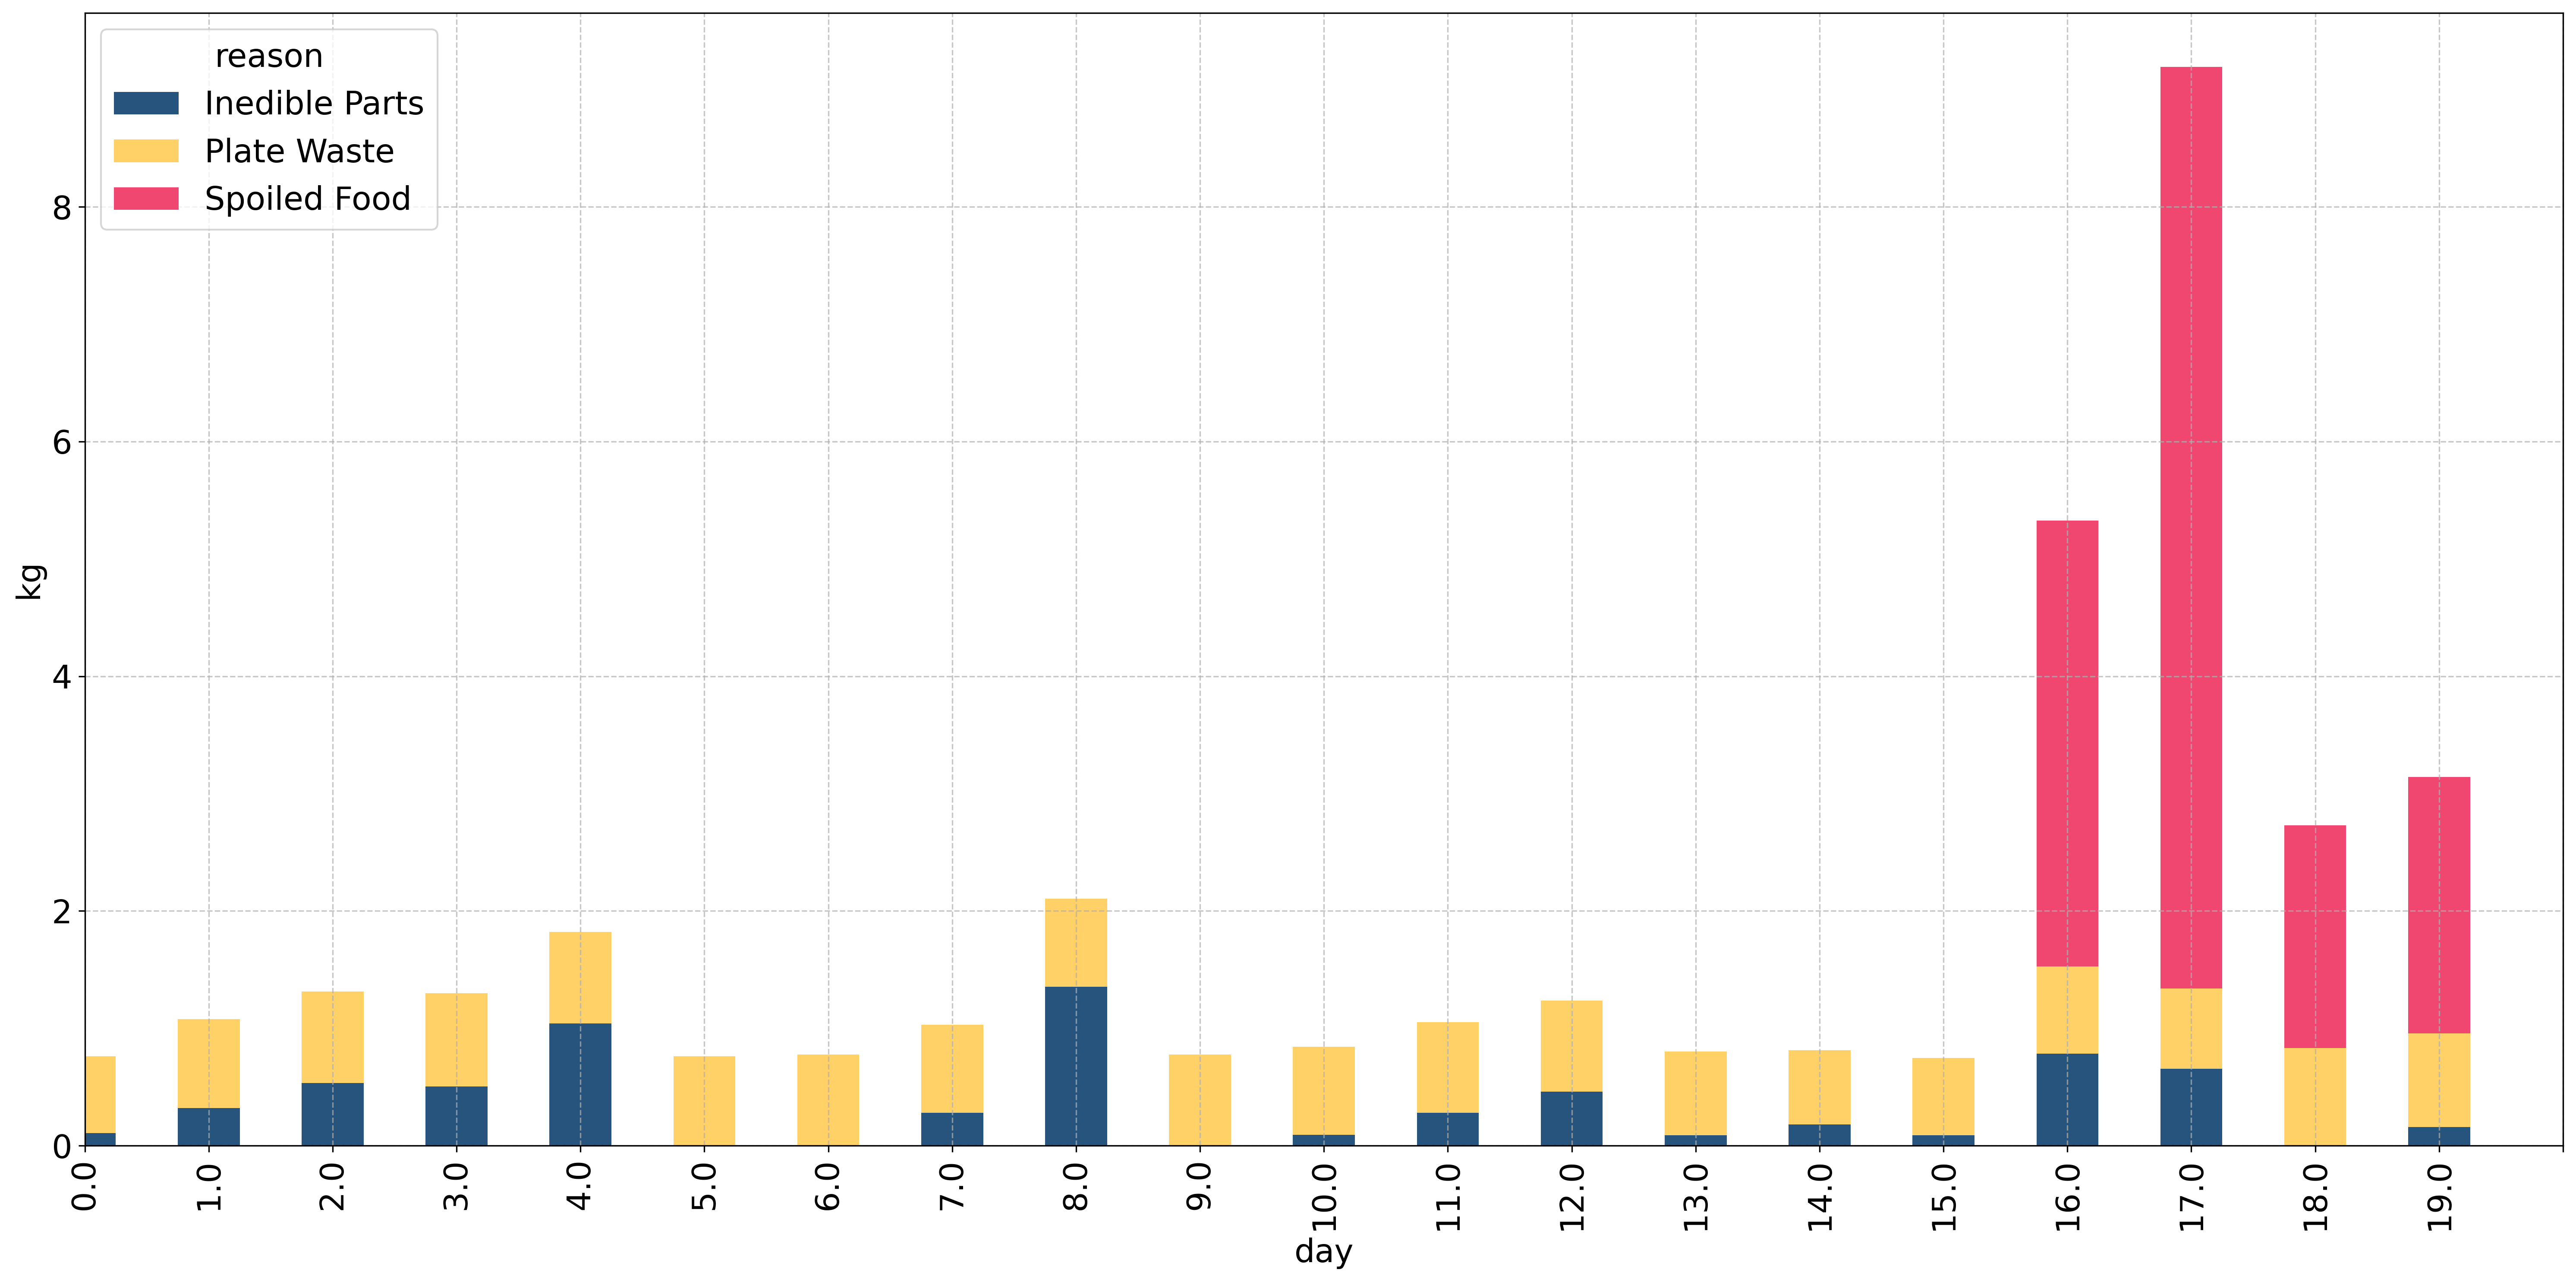

In [48]:
plot_waste_type_hh(data["run_0"], 0,"reason")
plot_waste_type_hh(data["run_1"], 0,"reason")
plot_waste_type_hh(data["run_2"], 0,"reason")


In [61]:
def plot_waste_type_hh(dataset, hhID, category):
    df_wasted = dataset["log_wasted"]
    
    if len(df_wasted) > 0 and all(col in df_wasted.columns for col in conversion_factors):
        df_wasted['kg'] = sum(df_wasted[col] * conversion_factors[col] for col in conversion_factors)
    
    hh_wasted = df_wasted[
        (df_wasted['household'] == hhID) & (df_wasted['kg'] > 0)
    ].groupby(['day', category])['kg'].sum()
    
    hh_wasted = hh_wasted.compute()
    hh_wasted = hh_wasted.unstack(fill_value=0)
    color_set = status_colors if category == "status" else reason_colors
    hh_wasted = hh_wasted.reindex(columns=color_set.keys(), fill_value=0)
    plt.figure(figsize=(20, 10), dpi=300)
    
    hh_wasted.plot(
        kind='bar', 
        stacked=True, 
        color=[color_set.get(col, 'gray') for col in hh_wasted.columns], 
        ax=plt.gca()
    )
    
    plt.xlabel("day", fontsize=18)
    plt.xlim(0, int(DAYS))
    plt.xticks(range(0, int(DAYS) + 1, 1)) 
    plt.ylabel("kg", fontsize=18)
    plt.legend(title=category, fontsize=18, title_fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


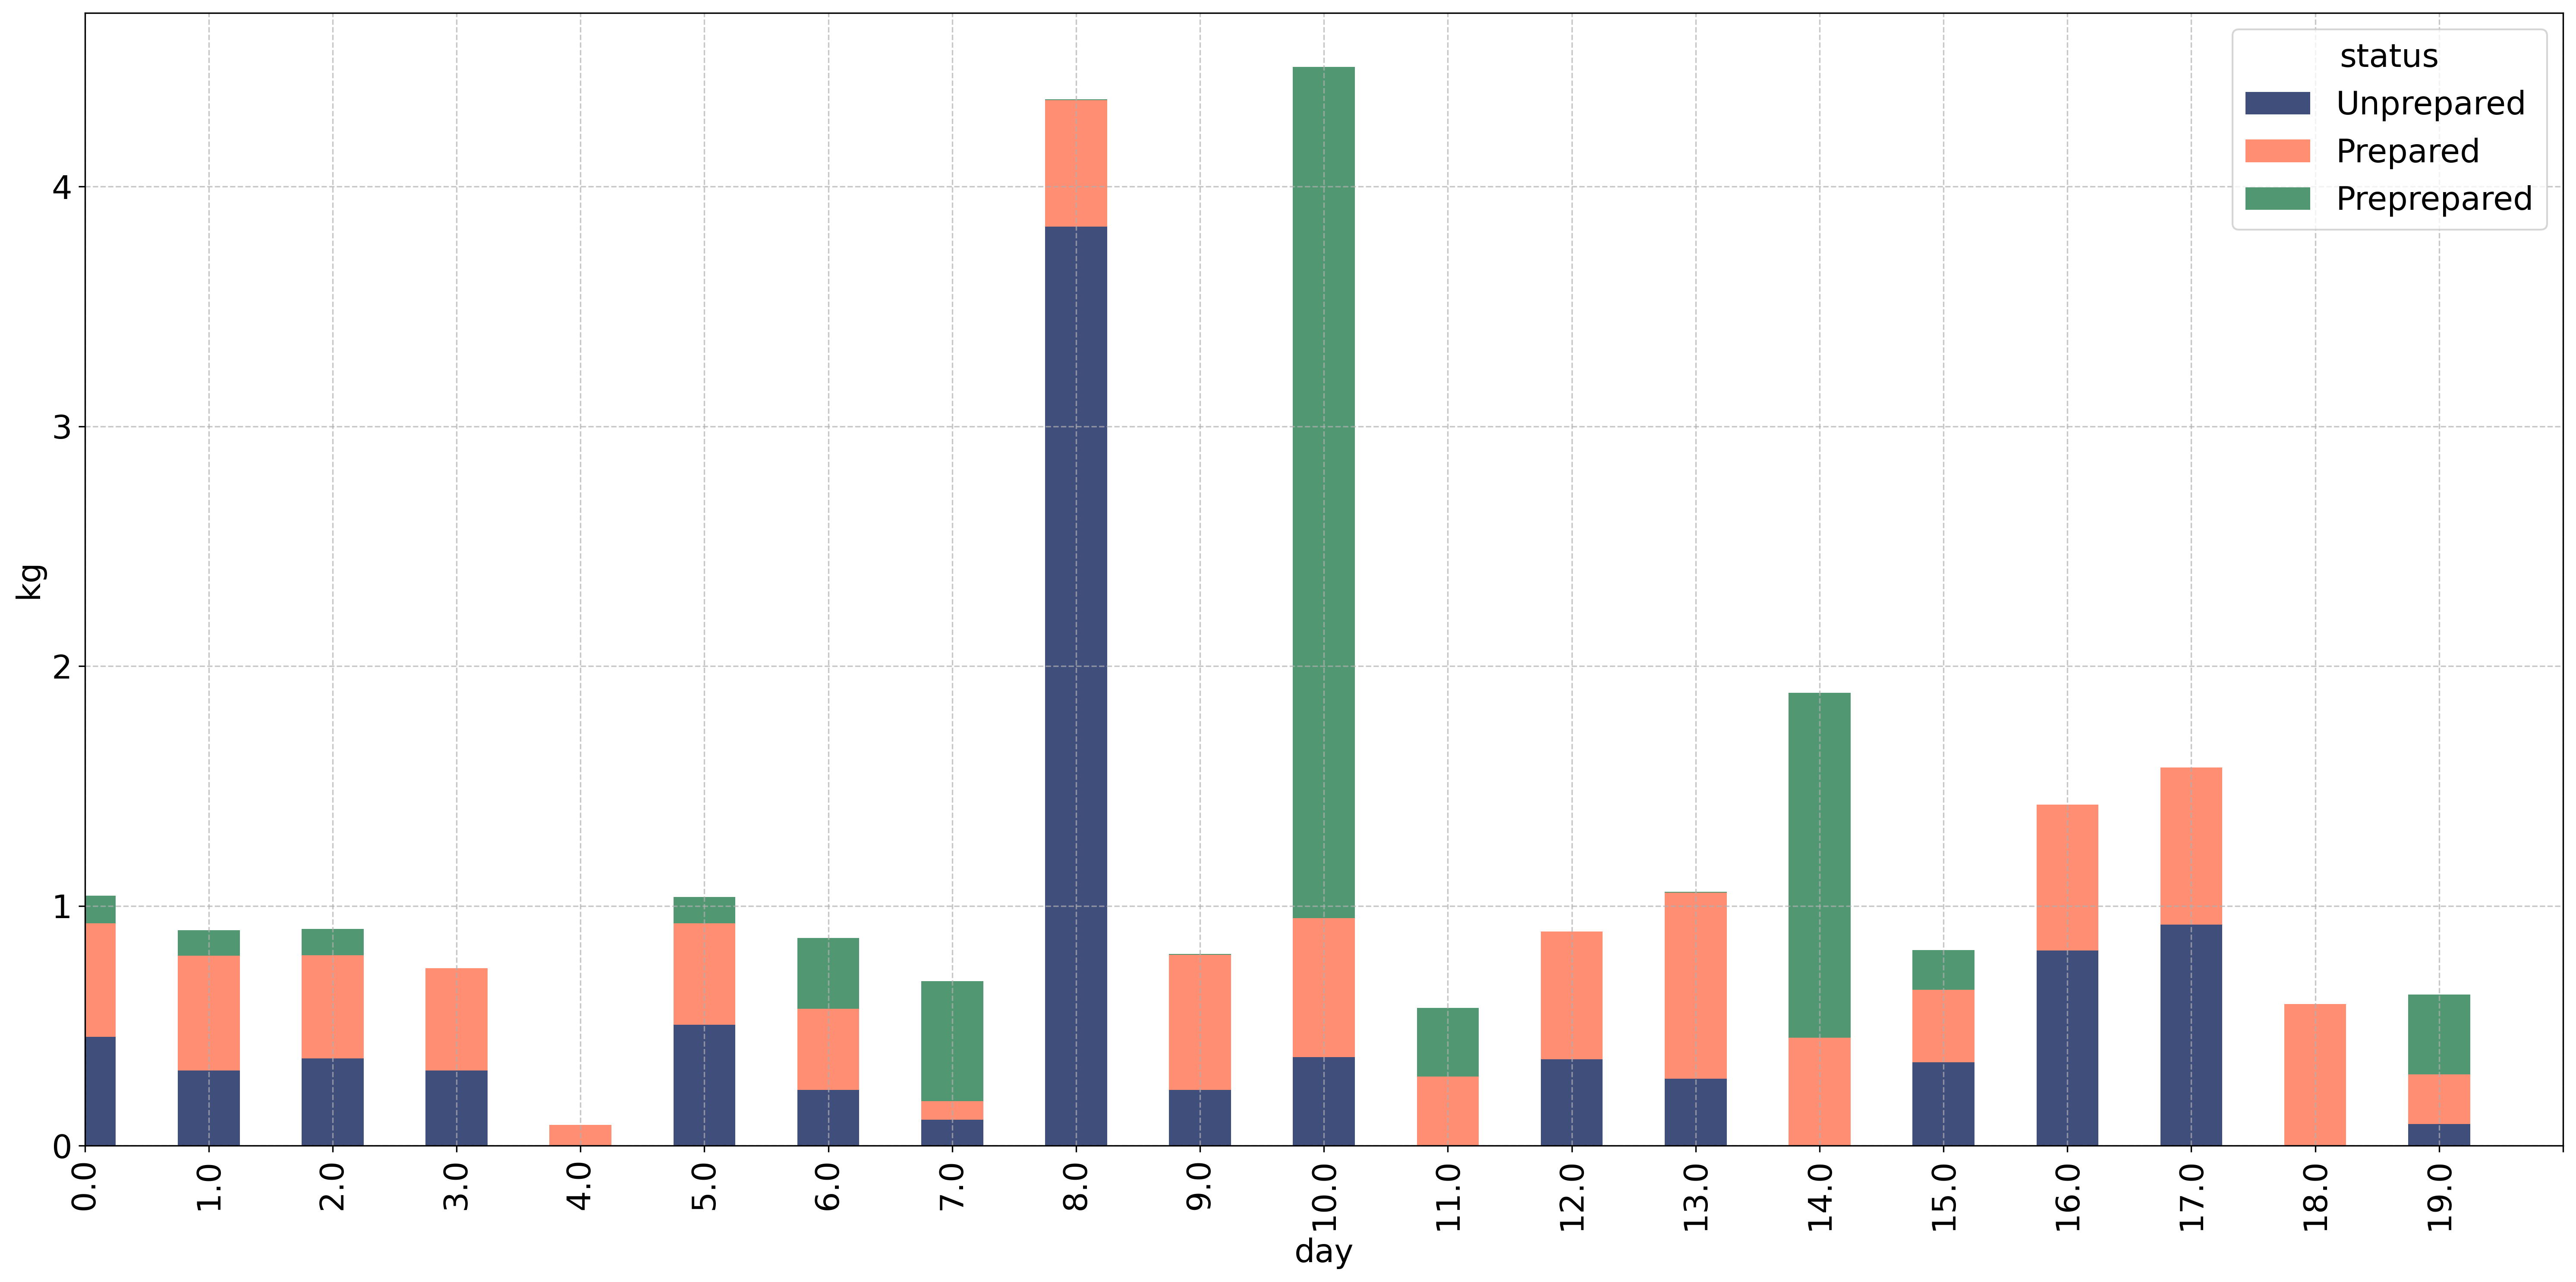

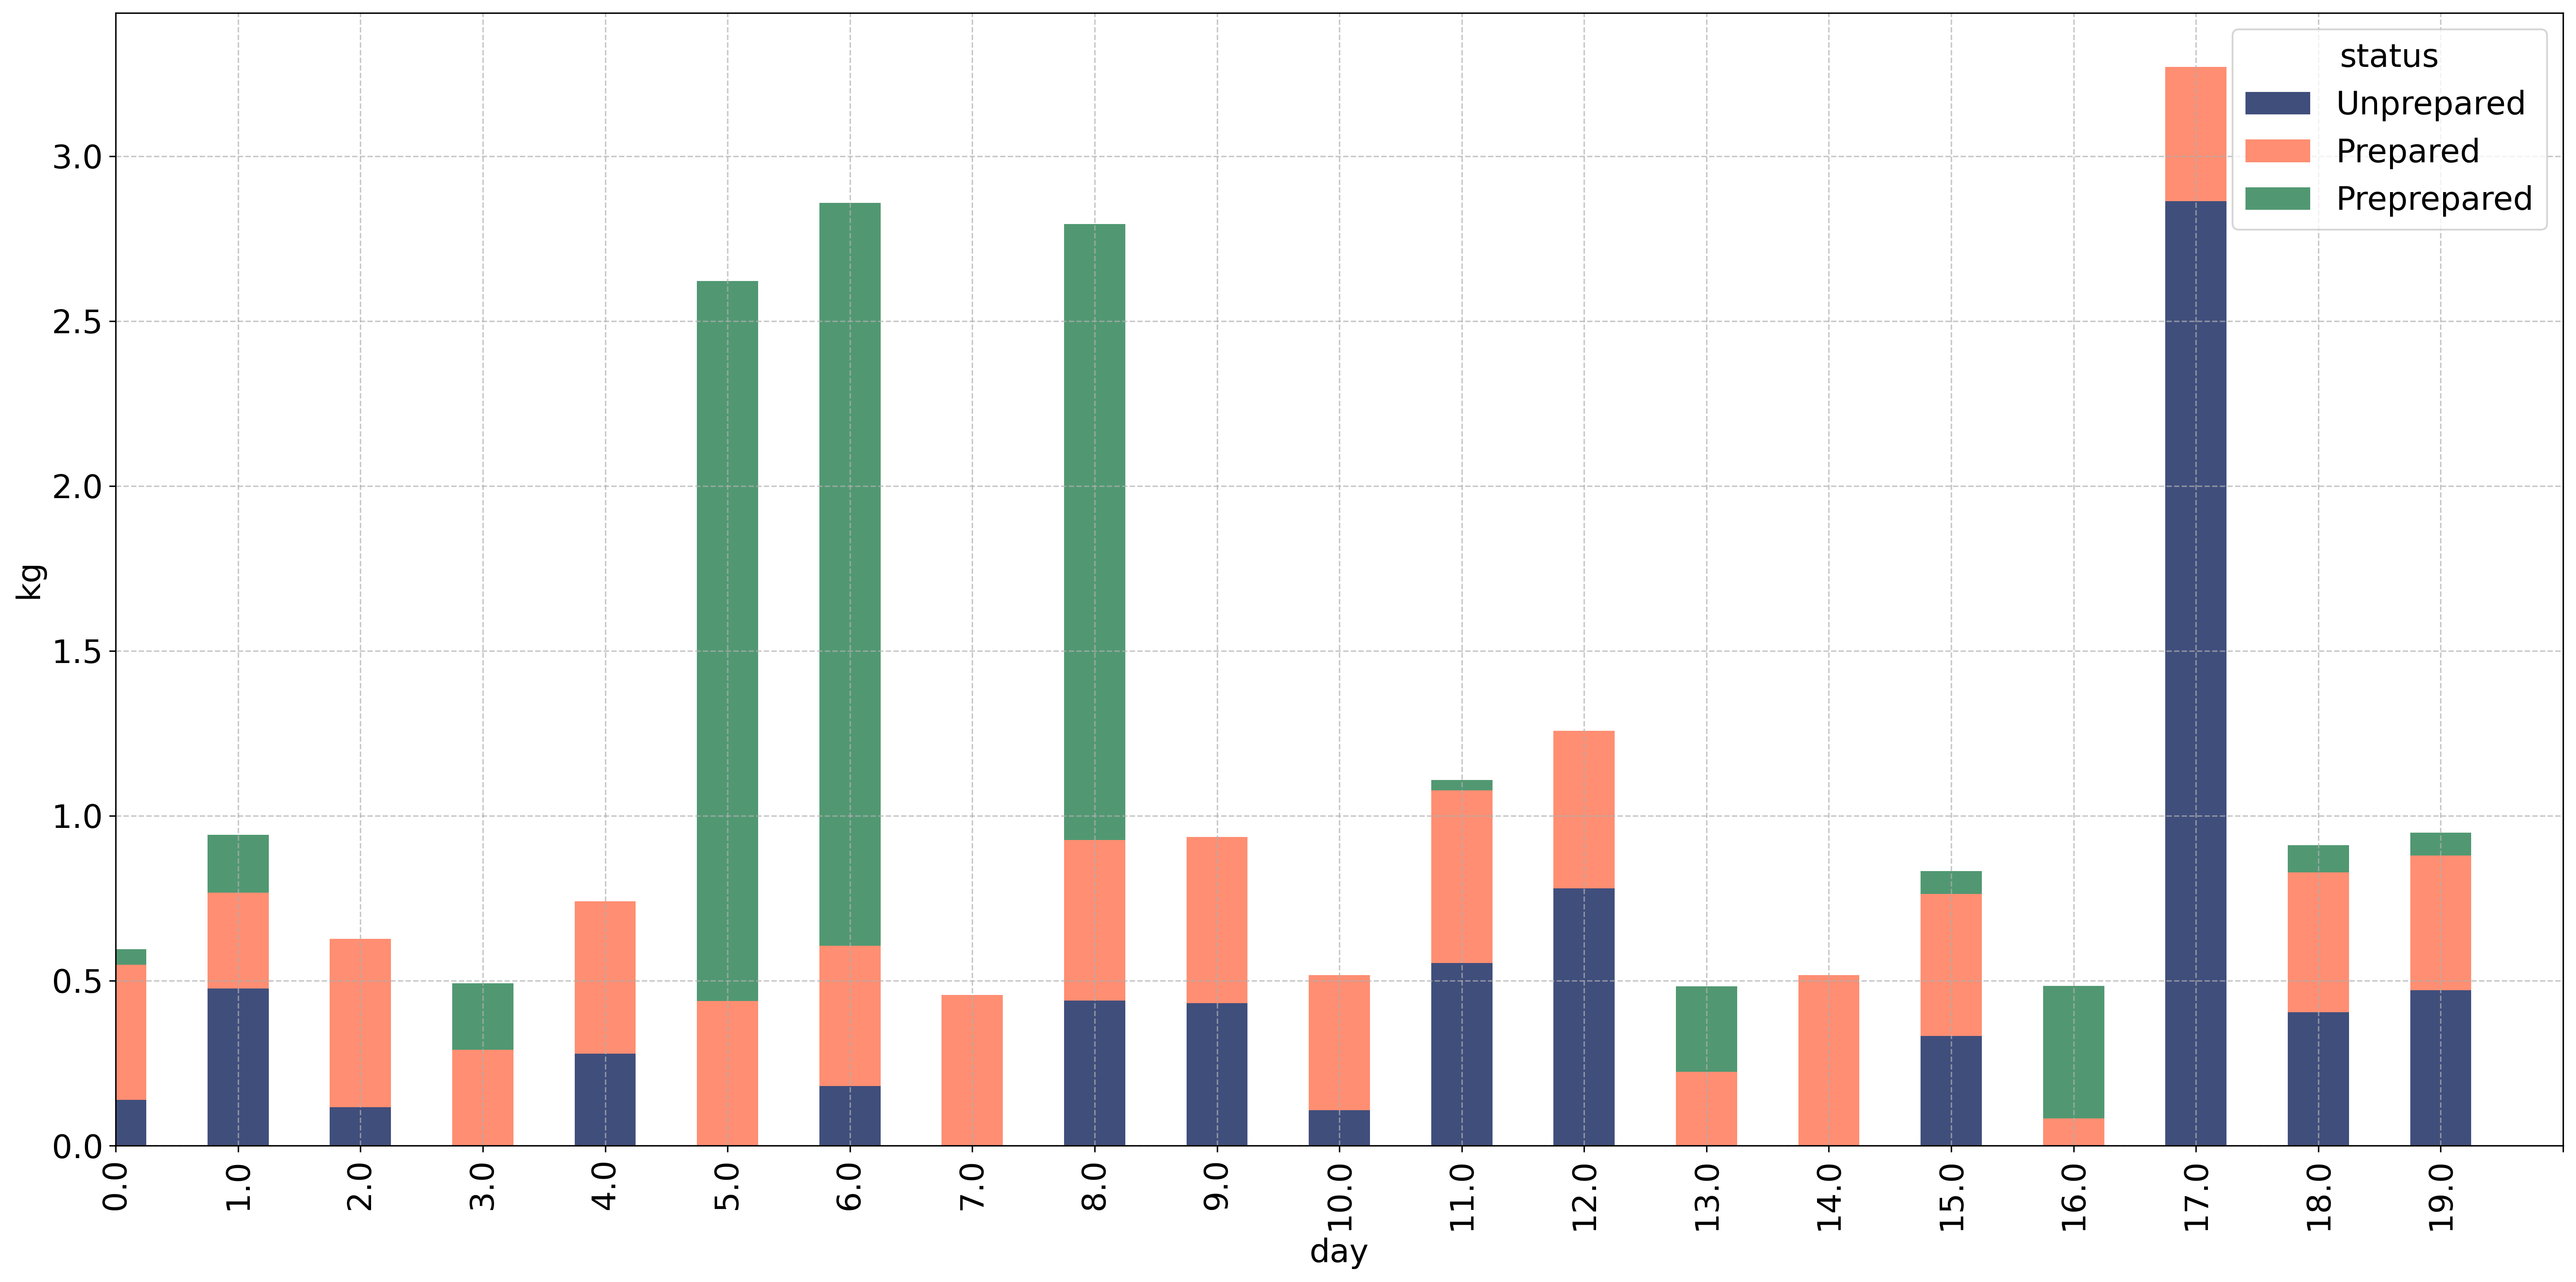

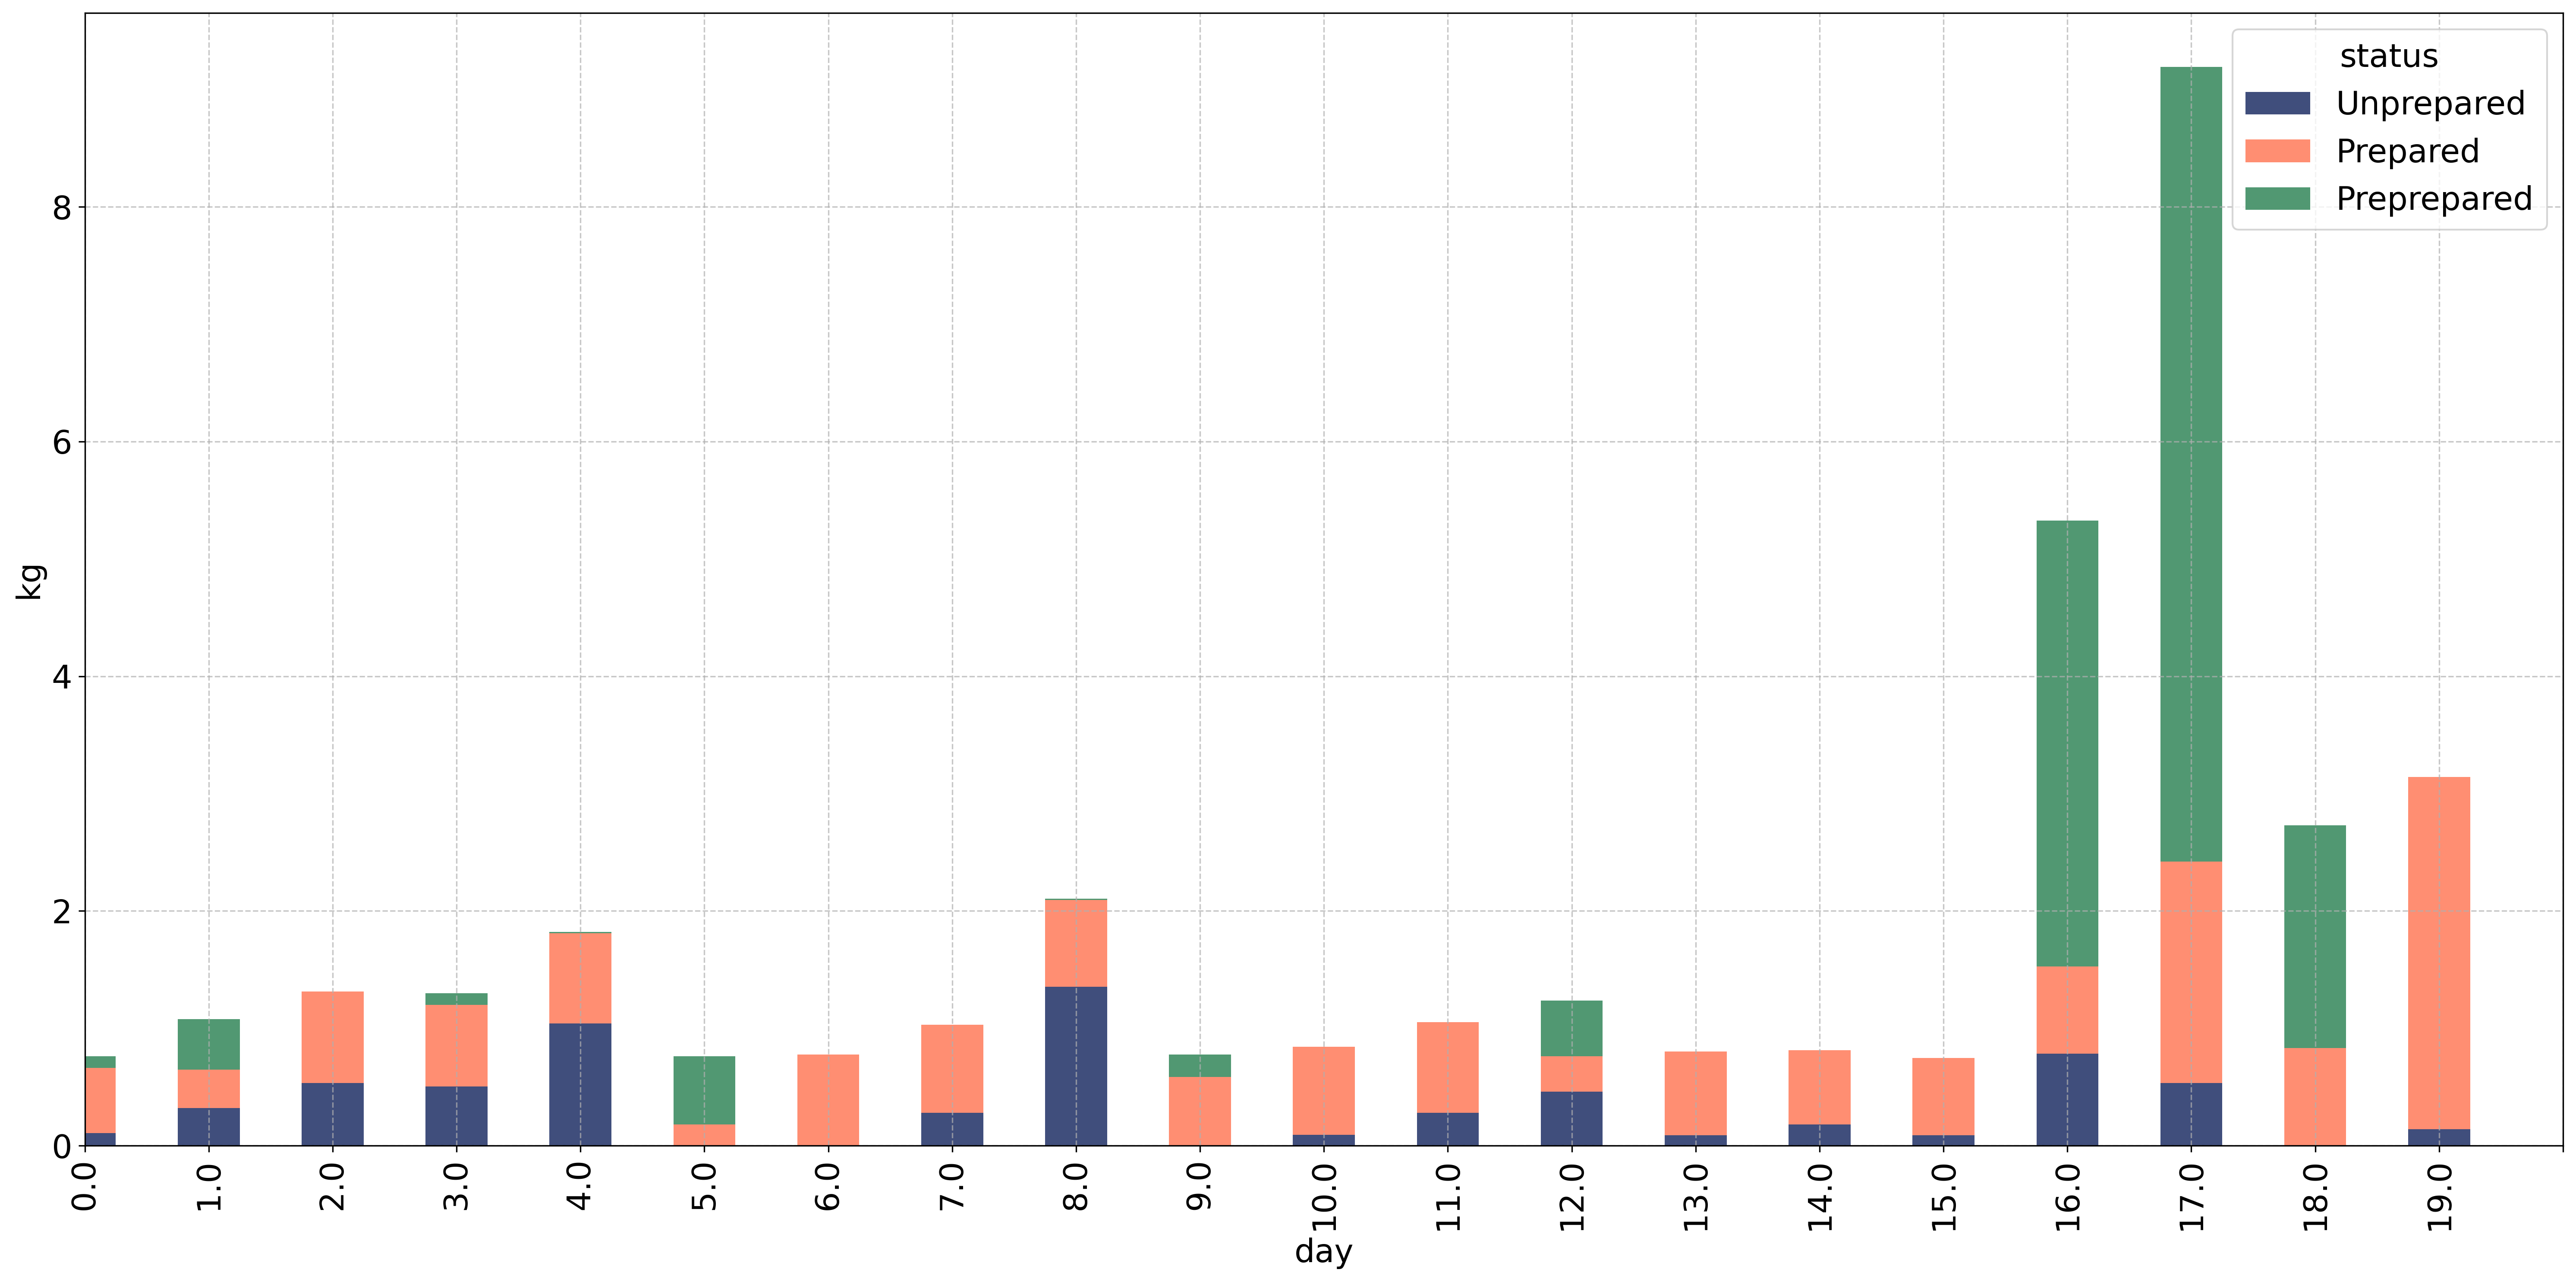

In [62]:
plot_waste_type_hh(data["run_0"], 0,"status")
plot_waste_type_hh(data["run_1"], 0,"status")
plot_waste_type_hh(data["run_2"], 0,"status")


In [70]:
hhsize = "run_0"
# Assuming df is already loaded with the Dask DataFrame
df = data[hhsize]["log_wasted"]
household_id = "0_0"  # Set the desired household ID
filtered_df = df[(df['household'] == household_id) & (df["kg"] > 0)]

# Group and aggregate the data
grouped_df = filtered_df.groupby('day')[food_categories].sum().compute().sort_index()

# Get Level of Concern
loc = data[hhsize]["log_hh_config"][data[hhsize]["log_hh_config"]["household"] == household_id]["lvl_of_concern"].compute().iloc[0]

# Plotting the stacked bar chart
plt.figure(figsize=(14, 8))
ax = grouped_df.plot(kind='bar', stacked=True, color=[color_mapping.get(cat, 'gray') for cat in grouped_df.columns], ax=plt.gca())
plt.title(f'Food Waste for Household: {hhsize[0]} Adults, {hhsize[-2]} Children with LOC: {loc:.2f} over {DAYS} Days')
plt.xlabel('Day Wasted')
plt.ylabel('Servings of Food Wasted')
plt.legend(title='Food Categories')
plt.xticks(range(0, len(grouped_df), 10))
plt.tight_layout()
plt.show()

TypeError: unhashable type: 'dict_keys'